In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 738)
(3944610, 8)
validation
(464344, 738)
(464344, 8)
test
(574820, 738)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 9:05 - loss: 2.2303 - STD: 0.0684 - MAE: 0.2190

  5/395 [..............................] - ETA: 6s - loss: 2.1100 - STD: 0.0496 - MAE: 0.2170  

  8/395 [..............................] - ETA: 6s - loss: 2.0992 - STD: 0.0484 - MAE: 0.2168

 12/395 [..............................] - ETA: 6s - loss: 2.0848 - STD: 0.0451 - MAE: 0.2166

 16/395 [>.............................] - ETA: 6s - loss: 2.0772 - STD: 0.0419 - MAE: 0.2167

 20/395 [>.............................] - ETA: 6s - loss: 2.0717 - STD: 0.0391 - MAE: 0.2167

 23/395 [>.............................] - ETA: 6s - loss: 2.0671 - STD: 0.0383 - MAE: 0.2166

 26/395 [>.............................] - ETA: 6s - loss: 2.0629 - STD: 0.0383 - MAE: 0.2165

 29/395 [=>............................] - ETA: 6s - loss: 2.0581 - STD: 0.0381 - MAE: 0.2164

 32/395 [=>............................] - ETA: 6s - loss: 2.0518 - STD: 0.0381 - MAE: 0.2161

 35/395 [=>............................] - ETA: 6s - loss: 2.0444 - STD: 0.0387 - MAE: 0.2158

 38/395 [=>............................] - ETA: 6s - loss: 2.0360 - STD: 0.0396 - MAE: 0.2155

 41/395 [==>...........................] - ETA: 6s - loss: 2.0270 - STD: 0.0412 - MAE: 0.2150

 44/395 [==>...........................] - ETA: 5s - loss: 2.0168 - STD: 0.0430 - MAE: 0.2145

 47/395 [==>...........................] - ETA: 5s - loss: 2.0067 - STD: 0.0446 - MAE: 0.2140

 50/395 [==>...........................] - ETA: 5s - loss: 1.9953 - STD: 0.0465 - MAE: 0.2134

 53/395 [===>..........................] - ETA: 5s - loss: 1.9836 - STD: 0.0483 - MAE: 0.2128

 56/395 [===>..........................] - ETA: 5s - loss: 1.9707 - STD: 0.0503 - MAE: 0.2122

 59/395 [===>..........................] - ETA: 5s - loss: 1.9576 - STD: 0.0524 - MAE: 0.2115

 62/395 [===>..........................] - ETA: 5s - loss: 1.9437 - STD: 0.0545 - MAE: 0.2108

 66/395 [====>.........................] - ETA: 5s - loss: 1.9245 - STD: 0.0574 - MAE: 0.2097

 69/395 [====>.........................] - ETA: 5s - loss: 1.9099 - STD: 0.0597 - MAE: 0.2088

 72/395 [====>.........................] - ETA: 5s - loss: 1.8947 - STD: 0.0620 - MAE: 0.2080

 76/395 [====>.........................] - ETA: 5s - loss: 1.8751 - STD: 0.0650 - MAE: 0.2068

 79/395 [=====>........................] - ETA: 5s - loss: 1.8606 - STD: 0.0673 - MAE: 0.2059

 82/395 [=====>........................] - ETA: 5s - loss: 1.8469 - STD: 0.0696 - MAE: 0.2050

 85/395 [=====>........................] - ETA: 5s - loss: 1.8338 - STD: 0.0719 - MAE: 0.2042

 89/395 [=====>........................] - ETA: 5s - loss: 1.8171 - STD: 0.0747 - MAE: 0.2030

 92/395 [=====>........................] - ETA: 5s - loss: 1.8051 - STD: 0.0768 - MAE: 0.2022

 93/395 [======>.......................] - ETA: 7s - loss: 1.8034 - STD: 0.0775 - MAE: 0.2020

 96/395 [======>.......................] - ETA: 7s - loss: 1.7919 - STD: 0.0794 - MAE: 0.2012

100/395 [======>.......................] - ETA: 7s - loss: 1.7776 - STD: 0.0818 - MAE: 0.2002

103/395 [======>.......................] - ETA: 6s - loss: 1.7672 - STD: 0.0835 - MAE: 0.1995

107/395 [=======>......................] - ETA: 6s - loss: 1.7540 - STD: 0.0857 - MAE: 0.1986

111/395 [=======>......................] - ETA: 6s - loss: 1.7414 - STD: 0.0878 - MAE: 0.1977

115/395 [=======>......................] - ETA: 6s - loss: 1.7295 - STD: 0.0898 - MAE: 0.1969

119/395 [========>.....................] - ETA: 6s - loss: 1.7177 - STD: 0.0917 - MAE: 0.1961

123/395 [========>.....................] - ETA: 6s - loss: 1.7066 - STD: 0.0936 - MAE: 0.1953

126/395 [========>.....................] - ETA: 5s - loss: 1.6984 - STD: 0.0949 - MAE: 0.1947

129/395 [========>.....................] - ETA: 5s - loss: 1.6904 - STD: 0.0963 - MAE: 0.1941

133/395 [=========>....................] - ETA: 5s - loss: 1.6802 - STD: 0.0980 - MAE: 0.1933

137/395 [=========>....................] - ETA: 5s - loss: 1.6704 - STD: 0.0996 - MAE: 0.1926

140/395 [=========>....................] - ETA: 5s - loss: 1.6630 - STD: 0.1008 - MAE: 0.1920

143/395 [=========>....................] - ETA: 5s - loss: 1.6557 - STD: 0.1020 - MAE: 0.1915

146/395 [==========>...................] - ETA: 5s - loss: 1.6488 - STD: 0.1032 - MAE: 0.1909

150/395 [==========>...................] - ETA: 5s - loss: 1.6401 - STD: 0.1047 - MAE: 0.1902

153/395 [==========>...................] - ETA: 5s - loss: 1.6341 - STD: 0.1058 - MAE: 0.1897

157/395 [==========>...................] - ETA: 5s - loss: 1.6257 - STD: 0.1072 - MAE: 0.1891

160/395 [===========>..................] - ETA: 4s - loss: 1.6195 - STD: 0.1083 - MAE: 0.1886

164/395 [===========>..................] - ETA: 4s - loss: 1.6115 - STD: 0.1096 - MAE: 0.1880

167/395 [===========>..................] - ETA: 4s - loss: 1.6058 - STD: 0.1106 - MAE: 0.1875

171/395 [===========>..................] - ETA: 4s - loss: 1.5982 - STD: 0.1119 - MAE: 0.1869

174/395 [============>.................] - ETA: 4s - loss: 1.5927 - STD: 0.1128 - MAE: 0.1864

177/395 [============>.................] - ETA: 4s - loss: 1.5875 - STD: 0.1138 - MAE: 0.1860

180/395 [============>.................] - ETA: 4s - loss: 1.5822 - STD: 0.1147 - MAE: 0.1855

183/395 [============>.................] - ETA: 4s - loss: 1.5771 - STD: 0.1156 - MAE: 0.1851

186/395 [=============>................] - ETA: 4s - loss: 1.5723 - STD: 0.1164 - MAE: 0.1847

190/395 [=============>................] - ETA: 4s - loss: 1.5659 - STD: 0.1175 - MAE: 0.1842

193/395 [=============>................] - ETA: 4s - loss: 1.5613 - STD: 0.1184 - MAE: 0.1838

196/395 [=============>................] - ETA: 4s - loss: 1.5566 - STD: 0.1192 - MAE: 0.1834

199/395 [==============>...............] - ETA: 3s - loss: 1.5520 - STD: 0.1200 - MAE: 0.1830

203/395 [==============>...............] - ETA: 3s - loss: 1.5461 - STD: 0.1210 - MAE: 0.1825

206/395 [==============>...............] - ETA: 3s - loss: 1.5416 - STD: 0.1217 - MAE: 0.1821

210/395 [==============>...............] - ETA: 3s - loss: 1.5359 - STD: 0.1227 - MAE: 0.1816

213/395 [===============>..............] - ETA: 3s - loss: 1.5316 - STD: 0.1235 - MAE: 0.1812

217/395 [===============>..............] - ETA: 3s - loss: 1.5260 - STD: 0.1244 - MAE: 0.1808

221/395 [===============>..............] - ETA: 3s - loss: 1.5206 - STD: 0.1254 - MAE: 0.1803

225/395 [================>.............] - ETA: 3s - loss: 1.5155 - STD: 0.1263 - MAE: 0.1798

229/395 [================>.............] - ETA: 3s - loss: 1.5104 - STD: 0.1271 - MAE: 0.1794

232/395 [================>.............] - ETA: 3s - loss: 1.5068 - STD: 0.1278 - MAE: 0.1791

235/395 [================>.............] - ETA: 3s - loss: 1.5032 - STD: 0.1284 - MAE: 0.1788

238/395 [=================>............] - ETA: 3s - loss: 1.4996 - STD: 0.1290 - MAE: 0.1784

242/395 [=================>............] - ETA: 3s - loss: 1.4947 - STD: 0.1298 - MAE: 0.1780

245/395 [=================>............] - ETA: 2s - loss: 1.4914 - STD: 0.1304 - MAE: 0.1777

248/395 [=================>............] - ETA: 2s - loss: 1.4882 - STD: 0.1310 - MAE: 0.1774

251/395 [==================>...........] - ETA: 2s - loss: 1.4853 - STD: 0.1316 - MAE: 0.1772

255/395 [==================>...........] - ETA: 2s - loss: 1.4810 - STD: 0.1323 - MAE: 0.1768

258/395 [==================>...........] - ETA: 2s - loss: 1.4779 - STD: 0.1329 - MAE: 0.1765

262/395 [==================>...........] - ETA: 2s - loss: 1.4738 - STD: 0.1336 - MAE: 0.1761

266/395 [===================>..........] - ETA: 2s - loss: 1.4697 - STD: 0.1343 - MAE: 0.1758

270/395 [===================>..........] - ETA: 2s - loss: 1.4656 - STD: 0.1350 - MAE: 0.1754

274/395 [===================>..........] - ETA: 2s - loss: 1.4617 - STD: 0.1356 - MAE: 0.1751

278/395 [====================>.........] - ETA: 2s - loss: 1.4579 - STD: 0.1363 - MAE: 0.1747

282/395 [====================>.........] - ETA: 2s - loss: 1.4541 - STD: 0.1369 - MAE: 0.1744

285/395 [====================>.........] - ETA: 2s - loss: 1.4513 - STD: 0.1374 - MAE: 0.1742

288/395 [====================>.........] - ETA: 2s - loss: 1.4486 - STD: 0.1379 - MAE: 0.1739

291/395 [=====================>........] - ETA: 1s - loss: 1.4459 - STD: 0.1383 - MAE: 0.1737

294/395 [=====================>........] - ETA: 1s - loss: 1.4431 - STD: 0.1388 - MAE: 0.1734

297/395 [=====================>........] - ETA: 1s - loss: 1.4404 - STD: 0.1392 - MAE: 0.1732

301/395 [=====================>........] - ETA: 1s - loss: 1.4370 - STD: 0.1398 - MAE: 0.1729

304/395 [======================>.......] - ETA: 1s - loss: 1.4344 - STD: 0.1402 - MAE: 0.1727

308/395 [======================>.......] - ETA: 1s - loss: 1.4315 - STD: 0.1408 - MAE: 0.1724

311/395 [======================>.......] - ETA: 1s - loss: 1.4290 - STD: 0.1412 - MAE: 0.1722

314/395 [======================>.......] - ETA: 1s - loss: 1.4266 - STD: 0.1416 - MAE: 0.1719

318/395 [=======================>......] - ETA: 1s - loss: 1.4234 - STD: 0.1422 - MAE: 0.1717

322/395 [=======================>......] - ETA: 1s - loss: 1.4202 - STD: 0.1427 - MAE: 0.1714

325/395 [=======================>......] - ETA: 1s - loss: 1.4179 - STD: 0.1431 - MAE: 0.1712

329/395 [=======================>......] - ETA: 1s - loss: 1.4148 - STD: 0.1436 - MAE: 0.1709

333/395 [========================>.....] - ETA: 1s - loss: 1.4117 - STD: 0.1441 - MAE: 0.1706

336/395 [========================>.....] - ETA: 1s - loss: 1.4095 - STD: 0.1445 - MAE: 0.1704

339/395 [========================>.....] - ETA: 1s - loss: 1.4073 - STD: 0.1448 - MAE: 0.1702

342/395 [========================>.....] - ETA: 0s - loss: 1.4051 - STD: 0.1452 - MAE: 0.1700

345/395 [=========================>....] - ETA: 0s - loss: 1.4029 - STD: 0.1455 - MAE: 0.1698

349/395 [=========================>....] - ETA: 0s - loss: 1.4000 - STD: 0.1460 - MAE: 0.1696

353/395 [=========================>....] - ETA: 0s - loss: 1.3976 - STD: 0.1465 - MAE: 0.1693

357/395 [==========================>...] - ETA: 0s - loss: 1.3949 - STD: 0.1470 - MAE: 0.1691

361/395 [==========================>...] - ETA: 0s - loss: 1.3921 - STD: 0.1474 - MAE: 0.1688

365/395 [==========================>...] - ETA: 0s - loss: 1.3895 - STD: 0.1479 - MAE: 0.1686

368/395 [==========================>...] - ETA: 0s - loss: 1.3876 - STD: 0.1482 - MAE: 0.1684

371/395 [===========================>..] - ETA: 0s - loss: 1.3857 - STD: 0.1485 - MAE: 0.1682

374/395 [===========================>..] - ETA: 0s - loss: 1.3838 - STD: 0.1488 - MAE: 0.1681

377/395 [===========================>..] - ETA: 0s - loss: 1.3818 - STD: 0.1491 - MAE: 0.1679

381/395 [===========================>..] - ETA: 0s - loss: 1.3794 - STD: 0.1496 - MAE: 0.1677

384/395 [============================>.] - ETA: 0s - loss: 1.3775 - STD: 0.1499 - MAE: 0.1675

388/395 [============================>.] - ETA: 0s - loss: 1.3752 - STD: 0.1503 - MAE: 0.1673

391/395 [============================>.] - ETA: 0s - loss: 1.3735 - STD: 0.1506 - MAE: 0.1671

395/395 [==============================] - ETA: 0s - loss: 1.3710 - STD: 0.1510 - MAE: 0.1669

395/395 [==============================] - 10s 22ms/step - loss: 1.3710 - STD: 0.1510 - MAE: 0.1669 - val_loss: 1.1881 - val_STD: 0.1938 - val_MAE: 0.1448


Epoch 2/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1571 - STD: 0.1890 - MAE: 0.1469

  4/395 [..............................] - ETA: 6s - loss: 1.1441 - STD: 0.1895 - MAE: 0.1460 

  7/395 [..............................] - ETA: 6s - loss: 1.1401 - STD: 0.1897 - MAE: 0.1456

 10/395 [..............................] - ETA: 6s - loss: 1.1369 - STD: 0.1897 - MAE: 0.1455

 14/395 [>.............................] - ETA: 6s - loss: 1.1358 - STD: 0.1897 - MAE: 0.1455

 18/395 [>.............................] - ETA: 6s - loss: 1.1349 - STD: 0.1897 - MAE: 0.1454

 21/395 [>.............................] - ETA: 6s - loss: 1.1341 - STD: 0.1898 - MAE: 0.1453

 25/395 [>.............................] - ETA: 6s - loss: 1.1343 - STD: 0.1900 - MAE: 0.1453

 28/395 [=>............................] - ETA: 6s - loss: 1.1331 - STD: 0.1901 - MAE: 0.1452

 32/395 [=>............................] - ETA: 6s - loss: 1.1315 - STD: 0.1901 - MAE: 0.1451

 36/395 [=>............................] - ETA: 6s - loss: 1.1292 - STD: 0.1902 - MAE: 0.1449

 40/395 [==>...........................] - ETA: 5s - loss: 1.1290 - STD: 0.1903 - MAE: 0.1449

 43/395 [==>...........................] - ETA: 5s - loss: 1.1279 - STD: 0.1905 - MAE: 0.1448

 46/395 [==>...........................] - ETA: 5s - loss: 1.1275 - STD: 0.1906 - MAE: 0.1447

 50/395 [==>...........................] - ETA: 5s - loss: 1.1257 - STD: 0.1909 - MAE: 0.1445

 53/395 [===>..........................] - ETA: 5s - loss: 1.1247 - STD: 0.1910 - MAE: 0.1444

 56/395 [===>..........................] - ETA: 5s - loss: 1.1243 - STD: 0.1911 - MAE: 0.1443

 60/395 [===>..........................] - ETA: 5s - loss: 1.1243 - STD: 0.1912 - MAE: 0.1443

 63/395 [===>..........................] - ETA: 5s - loss: 1.1262 - STD: 0.1913 - MAE: 0.1443

 67/395 [====>.........................] - ETA: 5s - loss: 1.1267 - STD: 0.1913 - MAE: 0.1443

 71/395 [====>.........................] - ETA: 5s - loss: 1.1261 - STD: 0.1914 - MAE: 0.1443

 74/395 [====>.........................] - ETA: 5s - loss: 1.1254 - STD: 0.1915 - MAE: 0.1442

 77/395 [====>.........................] - ETA: 5s - loss: 1.1248 - STD: 0.1915 - MAE: 0.1442

 81/395 [=====>........................] - ETA: 5s - loss: 1.1243 - STD: 0.1916 - MAE: 0.1441

 84/395 [=====>........................] - ETA: 5s - loss: 1.1240 - STD: 0.1916 - MAE: 0.1441

 87/395 [=====>........................] - ETA: 5s - loss: 1.1240 - STD: 0.1917 - MAE: 0.1441

 91/395 [=====>........................] - ETA: 5s - loss: 1.1235 - STD: 0.1917 - MAE: 0.1440

 95/395 [======>.......................] - ETA: 5s - loss: 1.1227 - STD: 0.1918 - MAE: 0.1440

 98/395 [======>.......................] - ETA: 4s - loss: 1.1222 - STD: 0.1918 - MAE: 0.1439

101/395 [======>.......................] - ETA: 4s - loss: 1.1214 - STD: 0.1919 - MAE: 0.1439

105/395 [======>.......................] - ETA: 4s - loss: 1.1204 - STD: 0.1920 - MAE: 0.1438

108/395 [=======>......................] - ETA: 4s - loss: 1.1196 - STD: 0.1920 - MAE: 0.1437

111/395 [=======>......................] - ETA: 4s - loss: 1.1188 - STD: 0.1921 - MAE: 0.1436

114/395 [=======>......................] - ETA: 4s - loss: 1.1184 - STD: 0.1922 - MAE: 0.1436

118/395 [=======>......................] - ETA: 4s - loss: 1.1185 - STD: 0.1923 - MAE: 0.1436

122/395 [========>.....................] - ETA: 4s - loss: 1.1180 - STD: 0.1924 - MAE: 0.1435

126/395 [========>.....................] - ETA: 4s - loss: 1.1171 - STD: 0.1924 - MAE: 0.1434

129/395 [========>.....................] - ETA: 4s - loss: 1.1165 - STD: 0.1925 - MAE: 0.1434

133/395 [=========>....................] - ETA: 4s - loss: 1.1155 - STD: 0.1926 - MAE: 0.1433

137/395 [=========>....................] - ETA: 4s - loss: 1.1143 - STD: 0.1927 - MAE: 0.1432

140/395 [=========>....................] - ETA: 4s - loss: 1.1138 - STD: 0.1927 - MAE: 0.1432

144/395 [=========>....................] - ETA: 4s - loss: 1.1129 - STD: 0.1928 - MAE: 0.1431

147/395 [==========>...................] - ETA: 4s - loss: 1.1123 - STD: 0.1929 - MAE: 0.1430

150/395 [==========>...................] - ETA: 4s - loss: 1.1116 - STD: 0.1929 - MAE: 0.1430

153/395 [==========>...................] - ETA: 4s - loss: 1.1109 - STD: 0.1930 - MAE: 0.1429

157/395 [==========>...................] - ETA: 3s - loss: 1.1104 - STD: 0.1931 - MAE: 0.1428

160/395 [===========>..................] - ETA: 3s - loss: 1.1098 - STD: 0.1932 - MAE: 0.1428

163/395 [===========>..................] - ETA: 3s - loss: 1.1093 - STD: 0.1933 - MAE: 0.1427

167/395 [===========>..................] - ETA: 3s - loss: 1.1089 - STD: 0.1934 - MAE: 0.1427

170/395 [===========>..................] - ETA: 3s - loss: 1.1090 - STD: 0.1934 - MAE: 0.1427

173/395 [============>.................] - ETA: 3s - loss: 1.1085 - STD: 0.1935 - MAE: 0.1426

177/395 [============>.................] - ETA: 3s - loss: 1.1081 - STD: 0.1936 - MAE: 0.1426

180/395 [============>.................] - ETA: 3s - loss: 1.1077 - STD: 0.1936 - MAE: 0.1425

184/395 [============>.................] - ETA: 3s - loss: 1.1072 - STD: 0.1937 - MAE: 0.1425

188/395 [=============>................] - ETA: 3s - loss: 1.1068 - STD: 0.1938 - MAE: 0.1424

192/395 [=============>................] - ETA: 3s - loss: 1.1060 - STD: 0.1938 - MAE: 0.1423

195/395 [=============>................] - ETA: 3s - loss: 1.1056 - STD: 0.1939 - MAE: 0.1423

199/395 [==============>...............] - ETA: 3s - loss: 1.1048 - STD: 0.1940 - MAE: 0.1422

202/395 [==============>...............] - ETA: 3s - loss: 1.1041 - STD: 0.1940 - MAE: 0.1422

206/395 [==============>...............] - ETA: 3s - loss: 1.1034 - STD: 0.1941 - MAE: 0.1421

210/395 [==============>...............] - ETA: 3s - loss: 1.1026 - STD: 0.1942 - MAE: 0.1421

214/395 [===============>..............] - ETA: 3s - loss: 1.1019 - STD: 0.1942 - MAE: 0.1420

217/395 [===============>..............] - ETA: 2s - loss: 1.1015 - STD: 0.1943 - MAE: 0.1420

221/395 [===============>..............] - ETA: 2s - loss: 1.1011 - STD: 0.1943 - MAE: 0.1419

225/395 [================>.............] - ETA: 2s - loss: 1.1006 - STD: 0.1944 - MAE: 0.1418

229/395 [================>.............] - ETA: 2s - loss: 1.0999 - STD: 0.1945 - MAE: 0.1418

232/395 [================>.............] - ETA: 2s - loss: 1.0994 - STD: 0.1945 - MAE: 0.1417

236/395 [================>.............] - ETA: 2s - loss: 1.0987 - STD: 0.1946 - MAE: 0.1417

240/395 [=================>............] - ETA: 2s - loss: 1.0981 - STD: 0.1947 - MAE: 0.1416

244/395 [=================>............] - ETA: 2s - loss: 1.0974 - STD: 0.1947 - MAE: 0.1416

248/395 [=================>............] - ETA: 2s - loss: 1.0969 - STD: 0.1948 - MAE: 0.1415

252/395 [==================>...........] - ETA: 2s - loss: 1.0963 - STD: 0.1949 - MAE: 0.1414

256/395 [==================>...........] - ETA: 2s - loss: 1.0956 - STD: 0.1949 - MAE: 0.1414

259/395 [==================>...........] - ETA: 2s - loss: 1.0952 - STD: 0.1950 - MAE: 0.1413

262/395 [==================>...........] - ETA: 2s - loss: 1.0952 - STD: 0.1951 - MAE: 0.1413

265/395 [===================>..........] - ETA: 2s - loss: 1.0948 - STD: 0.1951 - MAE: 0.1413

268/395 [===================>..........] - ETA: 2s - loss: 1.0945 - STD: 0.1952 - MAE: 0.1412

272/395 [===================>..........] - ETA: 2s - loss: 1.0942 - STD: 0.1953 - MAE: 0.1412

275/395 [===================>..........] - ETA: 1s - loss: 1.0937 - STD: 0.1953 - MAE: 0.1411

279/395 [====================>.........] - ETA: 1s - loss: 1.0932 - STD: 0.1954 - MAE: 0.1411

282/395 [====================>.........] - ETA: 1s - loss: 1.0927 - STD: 0.1954 - MAE: 0.1411

286/395 [====================>.........] - ETA: 1s - loss: 1.0921 - STD: 0.1955 - MAE: 0.1410

290/395 [=====================>........] - ETA: 1s - loss: 1.0916 - STD: 0.1956 - MAE: 0.1409

293/395 [=====================>........] - ETA: 1s - loss: 1.0912 - STD: 0.1956 - MAE: 0.1409

296/395 [=====================>........] - ETA: 1s - loss: 1.0908 - STD: 0.1957 - MAE: 0.1409

299/395 [=====================>........] - ETA: 1s - loss: 1.0902 - STD: 0.1957 - MAE: 0.1408

302/395 [=====================>........] - ETA: 1s - loss: 1.0898 - STD: 0.1958 - MAE: 0.1408

305/395 [======================>.......] - ETA: 1s - loss: 1.0893 - STD: 0.1958 - MAE: 0.1407

309/395 [======================>.......] - ETA: 1s - loss: 1.0887 - STD: 0.1959 - MAE: 0.1406

312/395 [======================>.......] - ETA: 1s - loss: 1.0882 - STD: 0.1960 - MAE: 0.1406

315/395 [======================>.......] - ETA: 1s - loss: 1.0878 - STD: 0.1960 - MAE: 0.1406

319/395 [=======================>......] - ETA: 1s - loss: 1.0872 - STD: 0.1961 - MAE: 0.1405

322/395 [=======================>......] - ETA: 1s - loss: 1.0867 - STD: 0.1961 - MAE: 0.1405

326/395 [=======================>......] - ETA: 1s - loss: 1.0862 - STD: 0.1962 - MAE: 0.1404

329/395 [=======================>......] - ETA: 1s - loss: 1.0858 - STD: 0.1963 - MAE: 0.1404

333/395 [========================>.....] - ETA: 1s - loss: 1.0852 - STD: 0.1963 - MAE: 0.1403

337/395 [========================>.....] - ETA: 0s - loss: 1.0845 - STD: 0.1964 - MAE: 0.1402

341/395 [========================>.....] - ETA: 0s - loss: 1.0840 - STD: 0.1965 - MAE: 0.1402

344/395 [=========================>....] - ETA: 0s - loss: 1.0836 - STD: 0.1965 - MAE: 0.1401

347/395 [=========================>....] - ETA: 0s - loss: 1.0831 - STD: 0.1966 - MAE: 0.1401

351/395 [=========================>....] - ETA: 0s - loss: 1.0824 - STD: 0.1967 - MAE: 0.1400

355/395 [=========================>....] - ETA: 0s - loss: 1.0819 - STD: 0.1967 - MAE: 0.1400

358/395 [==========================>...] - ETA: 0s - loss: 1.0815 - STD: 0.1968 - MAE: 0.1399

361/395 [==========================>...] - ETA: 0s - loss: 1.0811 - STD: 0.1969 - MAE: 0.1399

365/395 [==========================>...] - ETA: 0s - loss: 1.0806 - STD: 0.1969 - MAE: 0.1398

368/395 [==========================>...] - ETA: 0s - loss: 1.0802 - STD: 0.1970 - MAE: 0.1398

372/395 [===========================>..] - ETA: 0s - loss: 1.0797 - STD: 0.1970 - MAE: 0.1397

376/395 [===========================>..] - ETA: 0s - loss: 1.0792 - STD: 0.1971 - MAE: 0.1397

380/395 [===========================>..] - ETA: 0s - loss: 1.0787 - STD: 0.1972 - MAE: 0.1396

384/395 [============================>.] - ETA: 0s - loss: 1.0780 - STD: 0.1972 - MAE: 0.1396

388/395 [============================>.] - ETA: 0s - loss: 1.0773 - STD: 0.1973 - MAE: 0.1395

392/395 [============================>.] - ETA: 0s - loss: 1.0768 - STD: 0.1974 - MAE: 0.1394

395/395 [==============================] - 7s 18ms/step - loss: 1.0765 - STD: 0.1974 - MAE: 0.1394 - val_loss: 1.0730 - val_STD: 0.2080 - val_MAE: 0.1341


Epoch 3/10000


  1/395 [..............................] - ETA: 19s - loss: 1.0204 - STD: 0.2050 - MAE: 0.1335

  4/395 [..............................] - ETA: 6s - loss: 1.0343 - STD: 0.2052 - MAE: 0.1342 

  7/395 [..............................] - ETA: 6s - loss: 1.0327 - STD: 0.2050 - MAE: 0.1341

 10/395 [..............................] - ETA: 6s - loss: 1.0307 - STD: 0.2050 - MAE: 0.1340

 14/395 [>.............................] - ETA: 6s - loss: 1.0263 - STD: 0.2049 - MAE: 0.1338

 17/395 [>.............................] - ETA: 6s - loss: 1.0310 - STD: 0.2048 - MAE: 0.1341

 21/395 [>.............................] - ETA: 6s - loss: 1.0302 - STD: 0.2048 - MAE: 0.1340

 24/395 [>.............................] - ETA: 6s - loss: 1.0329 - STD: 0.2047 - MAE: 0.1342

 27/395 [=>............................] - ETA: 6s - loss: 1.0352 - STD: 0.2046 - MAE: 0.1344

 31/395 [=>............................] - ETA: 6s - loss: 1.0343 - STD: 0.2046 - MAE: 0.1343

 34/395 [=>............................] - ETA: 6s - loss: 1.0343 - STD: 0.2045 - MAE: 0.1344

 38/395 [=>............................] - ETA: 6s - loss: 1.0343 - STD: 0.2045 - MAE: 0.1344

 41/395 [==>...........................] - ETA: 5s - loss: 1.0333 - STD: 0.2045 - MAE: 0.1343

 45/395 [==>...........................] - ETA: 5s - loss: 1.0320 - STD: 0.2045 - MAE: 0.1342

 49/395 [==>...........................] - ETA: 5s - loss: 1.0303 - STD: 0.2045 - MAE: 0.1341

 53/395 [===>..........................] - ETA: 5s - loss: 1.0291 - STD: 0.2045 - MAE: 0.1341

 57/395 [===>..........................] - ETA: 5s - loss: 1.0274 - STD: 0.2046 - MAE: 0.1339

 60/395 [===>..........................] - ETA: 5s - loss: 1.0262 - STD: 0.2046 - MAE: 0.1339

 63/395 [===>..........................] - ETA: 5s - loss: 1.0254 - STD: 0.2047 - MAE: 0.1338

 67/395 [====>.........................] - ETA: 5s - loss: 1.0248 - STD: 0.2048 - MAE: 0.1337

 71/395 [====>.........................] - ETA: 5s - loss: 1.0247 - STD: 0.2048 - MAE: 0.1337

 74/395 [====>.........................] - ETA: 5s - loss: 1.0244 - STD: 0.2049 - MAE: 0.1337

 77/395 [====>.........................] - ETA: 5s - loss: 1.0242 - STD: 0.2049 - MAE: 0.1336

 80/395 [=====>........................] - ETA: 5s - loss: 1.0235 - STD: 0.2050 - MAE: 0.1336

 83/395 [=====>........................] - ETA: 5s - loss: 1.0226 - STD: 0.2050 - MAE: 0.1335

 86/395 [=====>........................] - ETA: 5s - loss: 1.0222 - STD: 0.2050 - MAE: 0.1335

 90/395 [=====>........................] - ETA: 5s - loss: 1.0215 - STD: 0.2051 - MAE: 0.1334

 93/395 [======>.......................] - ETA: 5s - loss: 1.0209 - STD: 0.2052 - MAE: 0.1333

 96/395 [======>.......................] - ETA: 5s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1333

100/395 [======>.......................] - ETA: 4s - loss: 1.0206 - STD: 0.2053 - MAE: 0.1333

103/395 [======>.......................] - ETA: 4s - loss: 1.0203 - STD: 0.2053 - MAE: 0.1333

107/395 [=======>......................] - ETA: 4s - loss: 1.0201 - STD: 0.2054 - MAE: 0.1332

111/395 [=======>......................] - ETA: 4s - loss: 1.0203 - STD: 0.2055 - MAE: 0.1332

115/395 [=======>......................] - ETA: 4s - loss: 1.0207 - STD: 0.2055 - MAE: 0.1332

119/395 [========>.....................] - ETA: 4s - loss: 1.0201 - STD: 0.2055 - MAE: 0.1332

122/395 [========>.....................] - ETA: 4s - loss: 1.0195 - STD: 0.2055 - MAE: 0.1331

125/395 [========>.....................] - ETA: 4s - loss: 1.0191 - STD: 0.2055 - MAE: 0.1331

128/395 [========>.....................] - ETA: 4s - loss: 1.0185 - STD: 0.2055 - MAE: 0.1331

131/395 [========>.....................] - ETA: 4s - loss: 1.0181 - STD: 0.2056 - MAE: 0.1330

134/395 [=========>....................] - ETA: 4s - loss: 1.0175 - STD: 0.2056 - MAE: 0.1330

138/395 [=========>....................] - ETA: 4s - loss: 1.0174 - STD: 0.2056 - MAE: 0.1330

141/395 [=========>....................] - ETA: 4s - loss: 1.0171 - STD: 0.2057 - MAE: 0.1329

144/395 [=========>....................] - ETA: 4s - loss: 1.0169 - STD: 0.2057 - MAE: 0.1329

148/395 [==========>...................] - ETA: 4s - loss: 1.0166 - STD: 0.2058 - MAE: 0.1329

152/395 [==========>...................] - ETA: 4s - loss: 1.0163 - STD: 0.2058 - MAE: 0.1328

155/395 [==========>...................] - ETA: 4s - loss: 1.0162 - STD: 0.2059 - MAE: 0.1328

158/395 [===========>..................] - ETA: 3s - loss: 1.0158 - STD: 0.2059 - MAE: 0.1328

161/395 [===========>..................] - ETA: 3s - loss: 1.0154 - STD: 0.2059 - MAE: 0.1327

164/395 [===========>..................] - ETA: 3s - loss: 1.0151 - STD: 0.2059 - MAE: 0.1327

168/395 [===========>..................] - ETA: 3s - loss: 1.0149 - STD: 0.2060 - MAE: 0.1327

172/395 [============>.................] - ETA: 3s - loss: 1.0144 - STD: 0.2061 - MAE: 0.1326

176/395 [============>.................] - ETA: 3s - loss: 1.0138 - STD: 0.2061 - MAE: 0.1326

180/395 [============>.................] - ETA: 3s - loss: 1.0133 - STD: 0.2061 - MAE: 0.1325

183/395 [============>.................] - ETA: 3s - loss: 1.0131 - STD: 0.2062 - MAE: 0.1325

187/395 [=============>................] - ETA: 3s - loss: 1.0129 - STD: 0.2062 - MAE: 0.1325

191/395 [=============>................] - ETA: 3s - loss: 1.0126 - STD: 0.2062 - MAE: 0.1324

194/395 [=============>................] - ETA: 3s - loss: 1.0125 - STD: 0.2063 - MAE: 0.1324

197/395 [=============>................] - ETA: 3s - loss: 1.0124 - STD: 0.2063 - MAE: 0.1324

201/395 [==============>...............] - ETA: 3s - loss: 1.0121 - STD: 0.2064 - MAE: 0.1324

205/395 [==============>...............] - ETA: 3s - loss: 1.0118 - STD: 0.2064 - MAE: 0.1323

209/395 [==============>...............] - ETA: 3s - loss: 1.0117 - STD: 0.2064 - MAE: 0.1323

212/395 [===============>..............] - ETA: 3s - loss: 1.0116 - STD: 0.2065 - MAE: 0.1323

215/395 [===============>..............] - ETA: 3s - loss: 1.0115 - STD: 0.2065 - MAE: 0.1323

219/395 [===============>..............] - ETA: 2s - loss: 1.0115 - STD: 0.2065 - MAE: 0.1323

223/395 [===============>..............] - ETA: 2s - loss: 1.0110 - STD: 0.2066 - MAE: 0.1322

226/395 [================>.............] - ETA: 2s - loss: 1.0106 - STD: 0.2066 - MAE: 0.1322

230/395 [================>.............] - ETA: 2s - loss: 1.0103 - STD: 0.2067 - MAE: 0.1321

234/395 [================>.............] - ETA: 2s - loss: 1.0099 - STD: 0.2067 - MAE: 0.1321

238/395 [=================>............] - ETA: 2s - loss: 1.0094 - STD: 0.2067 - MAE: 0.1321

242/395 [=================>............] - ETA: 2s - loss: 1.0090 - STD: 0.2068 - MAE: 0.1320

246/395 [=================>............] - ETA: 2s - loss: 1.0085 - STD: 0.2068 - MAE: 0.1320

250/395 [=================>............] - ETA: 2s - loss: 1.0082 - STD: 0.2069 - MAE: 0.1319

253/395 [==================>...........] - ETA: 2s - loss: 1.0080 - STD: 0.2069 - MAE: 0.1319

256/395 [==================>...........] - ETA: 2s - loss: 1.0076 - STD: 0.2069 - MAE: 0.1319

259/395 [==================>...........] - ETA: 2s - loss: 1.0074 - STD: 0.2070 - MAE: 0.1318

263/395 [==================>...........] - ETA: 2s - loss: 1.0071 - STD: 0.2070 - MAE: 0.1318

266/395 [===================>..........] - ETA: 2s - loss: 1.0069 - STD: 0.2071 - MAE: 0.1318

269/395 [===================>..........] - ETA: 2s - loss: 1.0066 - STD: 0.2071 - MAE: 0.1318

272/395 [===================>..........] - ETA: 2s - loss: 1.0062 - STD: 0.2071 - MAE: 0.1317

275/395 [===================>..........] - ETA: 2s - loss: 1.0058 - STD: 0.2072 - MAE: 0.1317

278/395 [====================>.........] - ETA: 1s - loss: 1.0055 - STD: 0.2072 - MAE: 0.1317

282/395 [====================>.........] - ETA: 1s - loss: 1.0050 - STD: 0.2072 - MAE: 0.1316

286/395 [====================>.........] - ETA: 1s - loss: 1.0048 - STD: 0.2073 - MAE: 0.1316

290/395 [=====================>........] - ETA: 1s - loss: 1.0050 - STD: 0.2073 - MAE: 0.1316

294/395 [=====================>........] - ETA: 1s - loss: 1.0048 - STD: 0.2074 - MAE: 0.1315

298/395 [=====================>........] - ETA: 1s - loss: 1.0044 - STD: 0.2074 - MAE: 0.1315

302/395 [=====================>........] - ETA: 1s - loss: 1.0041 - STD: 0.2075 - MAE: 0.1314

306/395 [======================>.......] - ETA: 1s - loss: 1.0038 - STD: 0.2075 - MAE: 0.1314

309/395 [======================>.......] - ETA: 1s - loss: 1.0036 - STD: 0.2075 - MAE: 0.1314

312/395 [======================>.......] - ETA: 1s - loss: 1.0035 - STD: 0.2076 - MAE: 0.1314

315/395 [======================>.......] - ETA: 1s - loss: 1.0035 - STD: 0.2076 - MAE: 0.1314

318/395 [=======================>......] - ETA: 1s - loss: 1.0033 - STD: 0.2076 - MAE: 0.1313

322/395 [=======================>......] - ETA: 1s - loss: 1.0031 - STD: 0.2076 - MAE: 0.1313

325/395 [=======================>......] - ETA: 1s - loss: 1.0029 - STD: 0.2077 - MAE: 0.1313

329/395 [=======================>......] - ETA: 1s - loss: 1.0025 - STD: 0.2077 - MAE: 0.1313

333/395 [========================>.....] - ETA: 1s - loss: 1.0021 - STD: 0.2077 - MAE: 0.1312

336/395 [========================>.....] - ETA: 0s - loss: 1.0018 - STD: 0.2078 - MAE: 0.1312

339/395 [========================>.....] - ETA: 0s - loss: 1.0015 - STD: 0.2078 - MAE: 0.1312

343/395 [=========================>....] - ETA: 0s - loss: 1.0013 - STD: 0.2079 - MAE: 0.1311

347/395 [=========================>....] - ETA: 0s - loss: 1.0010 - STD: 0.2079 - MAE: 0.1311

351/395 [=========================>....] - ETA: 0s - loss: 1.0006 - STD: 0.2079 - MAE: 0.1311

354/395 [=========================>....] - ETA: 0s - loss: 1.0003 - STD: 0.2080 - MAE: 0.1310

358/395 [==========================>...] - ETA: 0s - loss: 0.9999 - STD: 0.2080 - MAE: 0.1310

361/395 [==========================>...] - ETA: 0s - loss: 0.9996 - STD: 0.2080 - MAE: 0.1310

365/395 [==========================>...] - ETA: 0s - loss: 0.9994 - STD: 0.2081 - MAE: 0.1309

368/395 [==========================>...] - ETA: 0s - loss: 0.9991 - STD: 0.2081 - MAE: 0.1309

372/395 [===========================>..] - ETA: 0s - loss: 0.9988 - STD: 0.2081 - MAE: 0.1309

375/395 [===========================>..] - ETA: 0s - loss: 0.9985 - STD: 0.2082 - MAE: 0.1308

378/395 [===========================>..] - ETA: 0s - loss: 0.9982 - STD: 0.2082 - MAE: 0.1308

382/395 [============================>.] - ETA: 0s - loss: 0.9979 - STD: 0.2083 - MAE: 0.1308

385/395 [============================>.] - ETA: 0s - loss: 0.9977 - STD: 0.2083 - MAE: 0.1307

389/395 [============================>.] - ETA: 0s - loss: 0.9976 - STD: 0.2083 - MAE: 0.1307

392/395 [============================>.] - ETA: 0s - loss: 0.9975 - STD: 0.2084 - MAE: 0.1307

395/395 [==============================] - 7s 18ms/step - loss: 0.9972 - STD: 0.2084 - MAE: 0.1307 - val_loss: 1.1034 - val_STD: 0.2138 - val_MAE: 0.1343


Epoch 4/10000


  1/395 [..............................] - ETA: 16s - loss: 0.9765 - STD: 0.2117 - MAE: 0.1279

  4/395 [..............................] - ETA: 6s - loss: 0.9696 - STD: 0.2123 - MAE: 0.1274 

  8/395 [..............................] - ETA: 6s - loss: 0.9671 - STD: 0.2124 - MAE: 0.1272

 11/395 [..............................] - ETA: 6s - loss: 0.9657 - STD: 0.2124 - MAE: 0.1272

 15/395 [>.............................] - ETA: 6s - loss: 0.9636 - STD: 0.2125 - MAE: 0.1270

 18/395 [>.............................] - ETA: 6s - loss: 0.9643 - STD: 0.2125 - MAE: 0.1271

 21/395 [>.............................] - ETA: 6s - loss: 0.9640 - STD: 0.2125 - MAE: 0.1271

 25/395 [>.............................] - ETA: 6s - loss: 0.9647 - STD: 0.2124 - MAE: 0.1271

 29/395 [=>............................] - ETA: 6s - loss: 0.9650 - STD: 0.2125 - MAE: 0.1271

 32/395 [=>............................] - ETA: 6s - loss: 0.9678 - STD: 0.2125 - MAE: 0.1273

 36/395 [=>............................] - ETA: 5s - loss: 0.9690 - STD: 0.2126 - MAE: 0.1273

 40/395 [==>...........................] - ETA: 5s - loss: 0.9688 - STD: 0.2126 - MAE: 0.1273

 44/395 [==>...........................] - ETA: 5s - loss: 0.9691 - STD: 0.2127 - MAE: 0.1272

 48/395 [==>...........................] - ETA: 5s - loss: 0.9684 - STD: 0.2127 - MAE: 0.1272

 51/395 [==>...........................] - ETA: 5s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1273

 55/395 [===>..........................] - ETA: 5s - loss: 0.9681 - STD: 0.2127 - MAE: 0.1272

 59/395 [===>..........................] - ETA: 5s - loss: 0.9686 - STD: 0.2127 - MAE: 0.1273

 63/395 [===>..........................] - ETA: 5s - loss: 0.9686 - STD: 0.2127 - MAE: 0.1272

 67/395 [====>.........................] - ETA: 5s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1272

 70/395 [====>.........................] - ETA: 5s - loss: 0.9692 - STD: 0.2127 - MAE: 0.1273

 74/395 [====>.........................] - ETA: 5s - loss: 0.9686 - STD: 0.2127 - MAE: 0.1272

 77/395 [====>.........................] - ETA: 5s - loss: 0.9677 - STD: 0.2127 - MAE: 0.1272

 81/395 [=====>........................] - ETA: 5s - loss: 0.9675 - STD: 0.2128 - MAE: 0.1271

 85/395 [=====>........................] - ETA: 5s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1271

 88/395 [=====>........................] - ETA: 5s - loss: 0.9671 - STD: 0.2129 - MAE: 0.1271

 92/395 [=====>........................] - ETA: 5s - loss: 0.9665 - STD: 0.2129 - MAE: 0.1270

 96/395 [======>.......................] - ETA: 4s - loss: 0.9661 - STD: 0.2128 - MAE: 0.1270

100/395 [======>.......................] - ETA: 4s - loss: 0.9656 - STD: 0.2129 - MAE: 0.1270

104/395 [======>.......................] - ETA: 4s - loss: 0.9655 - STD: 0.2129 - MAE: 0.1270

107/395 [=======>......................] - ETA: 4s - loss: 0.9655 - STD: 0.2129 - MAE: 0.1270

110/395 [=======>......................] - ETA: 4s - loss: 0.9652 - STD: 0.2130 - MAE: 0.1269

113/395 [=======>......................] - ETA: 4s - loss: 0.9649 - STD: 0.2130 - MAE: 0.1269

116/395 [=======>......................] - ETA: 4s - loss: 0.9645 - STD: 0.2130 - MAE: 0.1269

119/395 [========>.....................] - ETA: 4s - loss: 0.9642 - STD: 0.2130 - MAE: 0.1268

122/395 [========>.....................] - ETA: 4s - loss: 0.9637 - STD: 0.2130 - MAE: 0.1268

125/395 [========>.....................] - ETA: 4s - loss: 0.9635 - STD: 0.2131 - MAE: 0.1268

128/395 [========>.....................] - ETA: 4s - loss: 0.9633 - STD: 0.2131 - MAE: 0.1268

132/395 [=========>....................] - ETA: 4s - loss: 0.9629 - STD: 0.2131 - MAE: 0.1267

136/395 [=========>....................] - ETA: 4s - loss: 0.9622 - STD: 0.2131 - MAE: 0.1267

139/395 [=========>....................] - ETA: 4s - loss: 0.9617 - STD: 0.2132 - MAE: 0.1266

142/395 [=========>....................] - ETA: 4s - loss: 0.9617 - STD: 0.2132 - MAE: 0.1266

145/395 [==========>...................] - ETA: 4s - loss: 0.9619 - STD: 0.2133 - MAE: 0.1266

148/395 [==========>...................] - ETA: 4s - loss: 0.9617 - STD: 0.2133 - MAE: 0.1266

151/395 [==========>...................] - ETA: 4s - loss: 0.9617 - STD: 0.2133 - MAE: 0.1266

154/395 [==========>...................] - ETA: 4s - loss: 0.9620 - STD: 0.2133 - MAE: 0.1266

158/395 [===========>..................] - ETA: 3s - loss: 0.9618 - STD: 0.2134 - MAE: 0.1265

161/395 [===========>..................] - ETA: 3s - loss: 0.9617 - STD: 0.2134 - MAE: 0.1265

164/395 [===========>..................] - ETA: 3s - loss: 0.9617 - STD: 0.2134 - MAE: 0.1265

167/395 [===========>..................] - ETA: 3s - loss: 0.9615 - STD: 0.2134 - MAE: 0.1265

170/395 [===========>..................] - ETA: 3s - loss: 0.9613 - STD: 0.2134 - MAE: 0.1265

173/395 [============>.................] - ETA: 3s - loss: 0.9617 - STD: 0.2134 - MAE: 0.1265

177/395 [============>.................] - ETA: 3s - loss: 0.9617 - STD: 0.2135 - MAE: 0.1265

180/395 [============>.................] - ETA: 3s - loss: 0.9618 - STD: 0.2135 - MAE: 0.1265

183/395 [============>.................] - ETA: 3s - loss: 0.9614 - STD: 0.2135 - MAE: 0.1265

186/395 [=============>................] - ETA: 3s - loss: 0.9612 - STD: 0.2135 - MAE: 0.1264

190/395 [=============>................] - ETA: 3s - loss: 0.9608 - STD: 0.2135 - MAE: 0.1264

194/395 [=============>................] - ETA: 3s - loss: 0.9605 - STD: 0.2136 - MAE: 0.1264

197/395 [=============>................] - ETA: 3s - loss: 0.9603 - STD: 0.2136 - MAE: 0.1264

200/395 [==============>...............] - ETA: 3s - loss: 0.9601 - STD: 0.2136 - MAE: 0.1264

203/395 [==============>...............] - ETA: 3s - loss: 0.9599 - STD: 0.2136 - MAE: 0.1263

206/395 [==============>...............] - ETA: 3s - loss: 0.9598 - STD: 0.2136 - MAE: 0.1263

209/395 [==============>...............] - ETA: 3s - loss: 0.9596 - STD: 0.2136 - MAE: 0.1263

212/395 [===============>..............] - ETA: 3s - loss: 0.9596 - STD: 0.2136 - MAE: 0.1263

215/395 [===============>..............] - ETA: 3s - loss: 0.9593 - STD: 0.2137 - MAE: 0.1263

218/395 [===============>..............] - ETA: 2s - loss: 0.9591 - STD: 0.2137 - MAE: 0.1263

221/395 [===============>..............] - ETA: 2s - loss: 0.9589 - STD: 0.2137 - MAE: 0.1262

224/395 [================>.............] - ETA: 2s - loss: 0.9588 - STD: 0.2137 - MAE: 0.1262

227/395 [================>.............] - ETA: 2s - loss: 0.9588 - STD: 0.2137 - MAE: 0.1262

231/395 [================>.............] - ETA: 2s - loss: 0.9585 - STD: 0.2138 - MAE: 0.1262

235/395 [================>.............] - ETA: 2s - loss: 0.9582 - STD: 0.2138 - MAE: 0.1262

239/395 [=================>............] - ETA: 2s - loss: 0.9581 - STD: 0.2138 - MAE: 0.1261

243/395 [=================>............] - ETA: 2s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

247/395 [=================>............] - ETA: 2s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

251/395 [==================>...........] - ETA: 2s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

254/395 [==================>...........] - ETA: 2s - loss: 0.9581 - STD: 0.2139 - MAE: 0.1261

257/395 [==================>...........] - ETA: 2s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

261/395 [==================>...........] - ETA: 2s - loss: 0.9582 - STD: 0.2139 - MAE: 0.1261

265/395 [===================>..........] - ETA: 2s - loss: 0.9582 - STD: 0.2140 - MAE: 0.1261

269/395 [===================>..........] - ETA: 2s - loss: 0.9580 - STD: 0.2140 - MAE: 0.1261

273/395 [===================>..........] - ETA: 2s - loss: 0.9578 - STD: 0.2140 - MAE: 0.1261

276/395 [===================>..........] - ETA: 2s - loss: 0.9577 - STD: 0.2140 - MAE: 0.1260

280/395 [====================>.........] - ETA: 1s - loss: 0.9574 - STD: 0.2140 - MAE: 0.1260

284/395 [====================>.........] - ETA: 1s - loss: 0.9569 - STD: 0.2141 - MAE: 0.1260

287/395 [====================>.........] - ETA: 1s - loss: 0.9566 - STD: 0.2141 - MAE: 0.1259

290/395 [=====================>........] - ETA: 1s - loss: 0.9564 - STD: 0.2141 - MAE: 0.1259

293/395 [=====================>........] - ETA: 1s - loss: 0.9563 - STD: 0.2141 - MAE: 0.1259

297/395 [=====================>........] - ETA: 1s - loss: 0.9560 - STD: 0.2141 - MAE: 0.1259

301/395 [=====================>........] - ETA: 1s - loss: 0.9558 - STD: 0.2142 - MAE: 0.1259

305/395 [======================>.......] - ETA: 1s - loss: 0.9555 - STD: 0.2142 - MAE: 0.1258

308/395 [======================>.......] - ETA: 1s - loss: 0.9552 - STD: 0.2142 - MAE: 0.1258

312/395 [======================>.......] - ETA: 1s - loss: 0.9549 - STD: 0.2142 - MAE: 0.1258

315/395 [======================>.......] - ETA: 1s - loss: 0.9547 - STD: 0.2143 - MAE: 0.1258

318/395 [=======================>......] - ETA: 1s - loss: 0.9545 - STD: 0.2143 - MAE: 0.1257

321/395 [=======================>......] - ETA: 1s - loss: 0.9543 - STD: 0.2143 - MAE: 0.1257

324/395 [=======================>......] - ETA: 1s - loss: 0.9542 - STD: 0.2143 - MAE: 0.1257

328/395 [=======================>......] - ETA: 1s - loss: 0.9540 - STD: 0.2143 - MAE: 0.1257

332/395 [========================>.....] - ETA: 1s - loss: 0.9538 - STD: 0.2144 - MAE: 0.1256

336/395 [========================>.....] - ETA: 0s - loss: 0.9535 - STD: 0.2144 - MAE: 0.1256

340/395 [========================>.....] - ETA: 0s - loss: 0.9533 - STD: 0.2144 - MAE: 0.1256

343/395 [=========================>....] - ETA: 0s - loss: 0.9532 - STD: 0.2145 - MAE: 0.1256

347/395 [=========================>....] - ETA: 0s - loss: 0.9528 - STD: 0.2145 - MAE: 0.1255

351/395 [=========================>....] - ETA: 0s - loss: 0.9527 - STD: 0.2145 - MAE: 0.1255

354/395 [=========================>....] - ETA: 0s - loss: 0.9526 - STD: 0.2145 - MAE: 0.1255

357/395 [==========================>...] - ETA: 0s - loss: 0.9524 - STD: 0.2146 - MAE: 0.1255

360/395 [==========================>...] - ETA: 0s - loss: 0.9522 - STD: 0.2146 - MAE: 0.1255

363/395 [==========================>...] - ETA: 0s - loss: 0.9519 - STD: 0.2146 - MAE: 0.1254

366/395 [==========================>...] - ETA: 0s - loss: 0.9518 - STD: 0.2146 - MAE: 0.1254

369/395 [===========================>..] - ETA: 0s - loss: 0.9517 - STD: 0.2147 - MAE: 0.1254

372/395 [===========================>..] - ETA: 0s - loss: 0.9514 - STD: 0.2147 - MAE: 0.1254

375/395 [===========================>..] - ETA: 0s - loss: 0.9512 - STD: 0.2147 - MAE: 0.1254

378/395 [===========================>..] - ETA: 0s - loss: 0.9510 - STD: 0.2147 - MAE: 0.1253

381/395 [===========================>..] - ETA: 0s - loss: 0.9511 - STD: 0.2147 - MAE: 0.1253

384/395 [============================>.] - ETA: 0s - loss: 0.9510 - STD: 0.2148 - MAE: 0.1253

387/395 [============================>.] - ETA: 0s - loss: 0.9509 - STD: 0.2148 - MAE: 0.1253

390/395 [============================>.] - ETA: 0s - loss: 0.9507 - STD: 0.2148 - MAE: 0.1253

394/395 [============================>.] - ETA: 0s - loss: 0.9505 - STD: 0.2148 - MAE: 0.1253

395/395 [==============================] - 7s 19ms/step - loss: 0.9505 - STD: 0.2148 - MAE: 0.1253 - val_loss: 1.0913 - val_STD: 0.2159 - val_MAE: 0.1325


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9232 - STD: 0.2151 - MAE: 0.1237

  4/395 [..............................] - ETA: 7s - loss: 0.9214 - STD: 0.2168 - MAE: 0.1227 

  8/395 [..............................] - ETA: 6s - loss: 0.9222 - STD: 0.2174 - MAE: 0.1225

 12/395 [..............................] - ETA: 6s - loss: 0.9252 - STD: 0.2173 - MAE: 0.1227

 16/395 [>.............................] - ETA: 6s - loss: 0.9245 - STD: 0.2174 - MAE: 0.1226

 20/395 [>.............................] - ETA: 6s - loss: 0.9254 - STD: 0.2175 - MAE: 0.1225

 24/395 [>.............................] - ETA: 6s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1226

 28/395 [=>............................] - ETA: 6s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1226

 32/395 [=>............................] - ETA: 5s - loss: 0.9304 - STD: 0.2177 - MAE: 0.1228

 36/395 [=>............................] - ETA: 5s - loss: 0.9324 - STD: 0.2176 - MAE: 0.1229

 40/395 [==>...........................] - ETA: 5s - loss: 0.9336 - STD: 0.2176 - MAE: 0.1230

 44/395 [==>...........................] - ETA: 5s - loss: 0.9342 - STD: 0.2176 - MAE: 0.1230

 48/395 [==>...........................] - ETA: 5s - loss: 0.9340 - STD: 0.2177 - MAE: 0.1230

 52/395 [==>...........................] - ETA: 5s - loss: 0.9336 - STD: 0.2176 - MAE: 0.1230

 56/395 [===>..........................] - ETA: 5s - loss: 0.9336 - STD: 0.2176 - MAE: 0.1230

 60/395 [===>..........................] - ETA: 5s - loss: 0.9333 - STD: 0.2177 - MAE: 0.1230

 64/395 [===>..........................] - ETA: 5s - loss: 0.9333 - STD: 0.2177 - MAE: 0.1229

 68/395 [====>.........................] - ETA: 5s - loss: 0.9339 - STD: 0.2177 - MAE: 0.1230

 72/395 [====>.........................] - ETA: 5s - loss: 0.9339 - STD: 0.2177 - MAE: 0.1230

 76/395 [====>.........................] - ETA: 5s - loss: 0.9335 - STD: 0.2176 - MAE: 0.1230

 80/395 [=====>........................] - ETA: 5s - loss: 0.9339 - STD: 0.2176 - MAE: 0.1230

 84/395 [=====>........................] - ETA: 5s - loss: 0.9340 - STD: 0.2176 - MAE: 0.1230

 88/395 [=====>........................] - ETA: 4s - loss: 0.9346 - STD: 0.2177 - MAE: 0.1230

 91/395 [=====>........................] - ETA: 4s - loss: 0.9346 - STD: 0.2177 - MAE: 0.1230

 95/395 [======>.......................] - ETA: 4s - loss: 0.9343 - STD: 0.2177 - MAE: 0.1230

 99/395 [======>.......................] - ETA: 4s - loss: 0.9340 - STD: 0.2177 - MAE: 0.1230

103/395 [======>.......................] - ETA: 4s - loss: 0.9332 - STD: 0.2177 - MAE: 0.1229

107/395 [=======>......................] - ETA: 4s - loss: 0.9325 - STD: 0.2177 - MAE: 0.1229

111/395 [=======>......................] - ETA: 4s - loss: 0.9322 - STD: 0.2178 - MAE: 0.1229

115/395 [=======>......................] - ETA: 4s - loss: 0.9319 - STD: 0.2178 - MAE: 0.1229

119/395 [========>.....................] - ETA: 4s - loss: 0.9322 - STD: 0.2178 - MAE: 0.1229

122/395 [========>.....................] - ETA: 4s - loss: 0.9321 - STD: 0.2178 - MAE: 0.1229

126/395 [========>.....................] - ETA: 4s - loss: 0.9319 - STD: 0.2178 - MAE: 0.1228

130/395 [========>.....................] - ETA: 4s - loss: 0.9312 - STD: 0.2178 - MAE: 0.1228

134/395 [=========>....................] - ETA: 4s - loss: 0.9307 - STD: 0.2179 - MAE: 0.1228

138/395 [=========>....................] - ETA: 4s - loss: 0.9305 - STD: 0.2179 - MAE: 0.1227

142/395 [=========>....................] - ETA: 4s - loss: 0.9300 - STD: 0.2179 - MAE: 0.1227

146/395 [==========>...................] - ETA: 4s - loss: 0.9294 - STD: 0.2179 - MAE: 0.1226

150/395 [==========>...................] - ETA: 3s - loss: 0.9290 - STD: 0.2179 - MAE: 0.1226

154/395 [==========>...................] - ETA: 3s - loss: 0.9286 - STD: 0.2180 - MAE: 0.1226

157/395 [==========>...................] - ETA: 3s - loss: 0.9283 - STD: 0.2180 - MAE: 0.1225

161/395 [===========>..................] - ETA: 3s - loss: 0.9277 - STD: 0.2180 - MAE: 0.1225

165/395 [===========>..................] - ETA: 3s - loss: 0.9270 - STD: 0.2181 - MAE: 0.1224

168/395 [===========>..................] - ETA: 3s - loss: 0.9268 - STD: 0.2181 - MAE: 0.1224

172/395 [============>.................] - ETA: 3s - loss: 0.9267 - STD: 0.2181 - MAE: 0.1224

176/395 [============>.................] - ETA: 3s - loss: 0.9269 - STD: 0.2182 - MAE: 0.1224

179/395 [============>.................] - ETA: 3s - loss: 0.9269 - STD: 0.2182 - MAE: 0.1224

183/395 [============>.................] - ETA: 3s - loss: 0.9265 - STD: 0.2182 - MAE: 0.1223

187/395 [=============>................] - ETA: 3s - loss: 0.9260 - STD: 0.2182 - MAE: 0.1223

191/395 [=============>................] - ETA: 3s - loss: 0.9255 - STD: 0.2183 - MAE: 0.1222

195/395 [=============>................] - ETA: 3s - loss: 0.9252 - STD: 0.2183 - MAE: 0.1222

198/395 [==============>...............] - ETA: 3s - loss: 0.9249 - STD: 0.2183 - MAE: 0.1222

202/395 [==============>...............] - ETA: 3s - loss: 0.9245 - STD: 0.2183 - MAE: 0.1222

206/395 [==============>...............] - ETA: 3s - loss: 0.9242 - STD: 0.2183 - MAE: 0.1221

210/395 [==============>...............] - ETA: 3s - loss: 0.9240 - STD: 0.2184 - MAE: 0.1221

213/395 [===============>..............] - ETA: 2s - loss: 0.9238 - STD: 0.2184 - MAE: 0.1221

217/395 [===============>..............] - ETA: 2s - loss: 0.9234 - STD: 0.2184 - MAE: 0.1220

221/395 [===============>..............] - ETA: 2s - loss: 0.9232 - STD: 0.2185 - MAE: 0.1220

225/395 [================>.............] - ETA: 2s - loss: 0.9229 - STD: 0.2185 - MAE: 0.1220

229/395 [================>.............] - ETA: 2s - loss: 0.9228 - STD: 0.2185 - MAE: 0.1220

233/395 [================>.............] - ETA: 2s - loss: 0.9226 - STD: 0.2186 - MAE: 0.1219

237/395 [=================>............] - ETA: 2s - loss: 0.9225 - STD: 0.2186 - MAE: 0.1219

241/395 [=================>............] - ETA: 2s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1219

245/395 [=================>............] - ETA: 2s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1219

248/395 [=================>............] - ETA: 2s - loss: 0.9224 - STD: 0.2186 - MAE: 0.1219

252/395 [==================>...........] - ETA: 2s - loss: 0.9225 - STD: 0.2187 - MAE: 0.1219

255/395 [==================>...........] - ETA: 2s - loss: 0.9224 - STD: 0.2187 - MAE: 0.1219

259/395 [==================>...........] - ETA: 2s - loss: 0.9224 - STD: 0.2187 - MAE: 0.1219

263/395 [==================>...........] - ETA: 2s - loss: 0.9224 - STD: 0.2187 - MAE: 0.1219

267/395 [===================>..........] - ETA: 2s - loss: 0.9223 - STD: 0.2187 - MAE: 0.1219

271/395 [===================>..........] - ETA: 2s - loss: 0.9220 - STD: 0.2188 - MAE: 0.1218

275/395 [===================>..........] - ETA: 1s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1218

279/395 [====================>.........] - ETA: 1s - loss: 0.9216 - STD: 0.2188 - MAE: 0.1218

283/395 [====================>.........] - ETA: 1s - loss: 0.9213 - STD: 0.2188 - MAE: 0.1218

287/395 [====================>.........] - ETA: 1s - loss: 0.9209 - STD: 0.2188 - MAE: 0.1217

290/395 [=====================>........] - ETA: 1s - loss: 0.9208 - STD: 0.2188 - MAE: 0.1217

293/395 [=====================>........] - ETA: 1s - loss: 0.9206 - STD: 0.2189 - MAE: 0.1217

297/395 [=====================>........] - ETA: 1s - loss: 0.9202 - STD: 0.2189 - MAE: 0.1217

300/395 [=====================>........] - ETA: 1s - loss: 0.9199 - STD: 0.2189 - MAE: 0.1216

303/395 [======================>.......] - ETA: 1s - loss: 0.9197 - STD: 0.2189 - MAE: 0.1216

307/395 [======================>.......] - ETA: 1s - loss: 0.9194 - STD: 0.2189 - MAE: 0.1216

310/395 [======================>.......] - ETA: 1s - loss: 0.9194 - STD: 0.2190 - MAE: 0.1216

314/395 [======================>.......] - ETA: 1s - loss: 0.9190 - STD: 0.2190 - MAE: 0.1215

318/395 [=======================>......] - ETA: 1s - loss: 0.9187 - STD: 0.2190 - MAE: 0.1215

321/395 [=======================>......] - ETA: 1s - loss: 0.9185 - STD: 0.2190 - MAE: 0.1215

324/395 [=======================>......] - ETA: 1s - loss: 0.9182 - STD: 0.2191 - MAE: 0.1215

328/395 [=======================>......] - ETA: 1s - loss: 0.9179 - STD: 0.2191 - MAE: 0.1214

331/395 [========================>.....] - ETA: 1s - loss: 0.9177 - STD: 0.2191 - MAE: 0.1214

335/395 [========================>.....] - ETA: 0s - loss: 0.9175 - STD: 0.2191 - MAE: 0.1214

339/395 [========================>.....] - ETA: 0s - loss: 0.9172 - STD: 0.2191 - MAE: 0.1214

342/395 [========================>.....] - ETA: 0s - loss: 0.9170 - STD: 0.2192 - MAE: 0.1213

346/395 [=========================>....] - ETA: 0s - loss: 0.9169 - STD: 0.2192 - MAE: 0.1213

350/395 [=========================>....] - ETA: 0s - loss: 0.9168 - STD: 0.2192 - MAE: 0.1213

354/395 [=========================>....] - ETA: 0s - loss: 0.9167 - STD: 0.2192 - MAE: 0.1213

358/395 [==========================>...] - ETA: 0s - loss: 0.9165 - STD: 0.2193 - MAE: 0.1213

361/395 [==========================>...] - ETA: 0s - loss: 0.9164 - STD: 0.2193 - MAE: 0.1213

364/395 [==========================>...] - ETA: 0s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1212

368/395 [==========================>...] - ETA: 0s - loss: 0.9161 - STD: 0.2193 - MAE: 0.1212

372/395 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2193 - MAE: 0.1212

376/395 [===========================>..] - ETA: 0s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1212

380/395 [===========================>..] - ETA: 0s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1212

383/395 [============================>.] - ETA: 0s - loss: 0.9154 - STD: 0.2194 - MAE: 0.1211

386/395 [============================>.] - ETA: 0s - loss: 0.9152 - STD: 0.2194 - MAE: 0.1211

390/395 [============================>.] - ETA: 0s - loss: 0.9149 - STD: 0.2194 - MAE: 0.1211

394/395 [============================>.] - ETA: 0s - loss: 0.9147 - STD: 0.2195 - MAE: 0.1211

395/395 [==============================] - 7s 18ms/step - loss: 0.9146 - STD: 0.2195 - MAE: 0.1211 - val_loss: 1.0559 - val_STD: 0.2212 - val_MAE: 0.1282


Epoch 6/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8912 - STD: 0.2224 - MAE: 0.1185

  4/395 [..............................] - ETA: 7s - loss: 0.9018 - STD: 0.2228 - MAE: 0.1189 

  7/395 [..............................] - ETA: 7s - loss: 0.9056 - STD: 0.2228 - MAE: 0.1191

 10/395 [..............................] - ETA: 7s - loss: 0.9012 - STD: 0.2226 - MAE: 0.1189

 13/395 [..............................] - ETA: 6s - loss: 0.8990 - STD: 0.2223 - MAE: 0.1189

 16/395 [>.............................] - ETA: 6s - loss: 0.8980 - STD: 0.2221 - MAE: 0.1189

 19/395 [>.............................] - ETA: 6s - loss: 0.8975 - STD: 0.2222 - MAE: 0.1188

 23/395 [>.............................] - ETA: 6s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1188

 26/395 [>.............................] - ETA: 6s - loss: 0.9043 - STD: 0.2223 - MAE: 0.1191

 30/395 [=>............................] - ETA: 6s - loss: 0.9077 - STD: 0.2223 - MAE: 0.1193

 33/395 [=>............................] - ETA: 6s - loss: 0.9080 - STD: 0.2224 - MAE: 0.1193

 37/395 [=>............................] - ETA: 6s - loss: 0.9089 - STD: 0.2223 - MAE: 0.1193

 41/395 [==>...........................] - ETA: 6s - loss: 0.9097 - STD: 0.2222 - MAE: 0.1194

 45/395 [==>...........................] - ETA: 5s - loss: 0.9089 - STD: 0.2221 - MAE: 0.1194

 49/395 [==>...........................] - ETA: 5s - loss: 0.9085 - STD: 0.2220 - MAE: 0.1195

 53/395 [===>..........................] - ETA: 5s - loss: 0.9085 - STD: 0.2219 - MAE: 0.1195

 56/395 [===>..........................] - ETA: 5s - loss: 0.9082 - STD: 0.2219 - MAE: 0.1195

 60/395 [===>..........................] - ETA: 5s - loss: 0.9079 - STD: 0.2218 - MAE: 0.1195

 64/395 [===>..........................] - ETA: 5s - loss: 0.9068 - STD: 0.2218 - MAE: 0.1195

 67/395 [====>.........................] - ETA: 5s - loss: 0.9065 - STD: 0.2218 - MAE: 0.1194

 70/395 [====>.........................] - ETA: 5s - loss: 0.9061 - STD: 0.2218 - MAE: 0.1194

 73/395 [====>.........................] - ETA: 5s - loss: 0.9058 - STD: 0.2218 - MAE: 0.1194

 77/395 [====>.........................] - ETA: 5s - loss: 0.9051 - STD: 0.2217 - MAE: 0.1194

 80/395 [=====>........................] - ETA: 5s - loss: 0.9043 - STD: 0.2217 - MAE: 0.1194

 84/395 [=====>........................] - ETA: 5s - loss: 0.9038 - STD: 0.2218 - MAE: 0.1193

 88/395 [=====>........................] - ETA: 5s - loss: 0.9032 - STD: 0.2218 - MAE: 0.1193

 92/395 [=====>........................] - ETA: 5s - loss: 0.9027 - STD: 0.2218 - MAE: 0.1192

 96/395 [======>.......................] - ETA: 4s - loss: 0.9019 - STD: 0.2218 - MAE: 0.1192

100/395 [======>.......................] - ETA: 4s - loss: 0.9011 - STD: 0.2218 - MAE: 0.1191

103/395 [======>.......................] - ETA: 4s - loss: 0.9009 - STD: 0.2218 - MAE: 0.1191

107/395 [=======>......................] - ETA: 4s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1191

111/395 [=======>......................] - ETA: 4s - loss: 0.9000 - STD: 0.2218 - MAE: 0.1191

115/395 [=======>......................] - ETA: 4s - loss: 0.9003 - STD: 0.2219 - MAE: 0.1191

119/395 [========>.....................] - ETA: 4s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1191

122/395 [========>.....................] - ETA: 4s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1190

125/395 [========>.....................] - ETA: 4s - loss: 0.8997 - STD: 0.2219 - MAE: 0.1190

129/395 [========>.....................] - ETA: 4s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1190

133/395 [=========>....................] - ETA: 4s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1190

136/395 [=========>....................] - ETA: 4s - loss: 0.8990 - STD: 0.2220 - MAE: 0.1190

139/395 [=========>....................] - ETA: 4s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1190

142/395 [=========>....................] - ETA: 4s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1190

146/395 [==========>...................] - ETA: 4s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1190

150/395 [==========>...................] - ETA: 4s - loss: 0.8986 - STD: 0.2220 - MAE: 0.1189

153/395 [==========>...................] - ETA: 4s - loss: 0.8982 - STD: 0.2220 - MAE: 0.1189

157/395 [==========>...................] - ETA: 3s - loss: 0.8979 - STD: 0.2220 - MAE: 0.1189

160/395 [===========>..................] - ETA: 3s - loss: 0.8975 - STD: 0.2220 - MAE: 0.1188

164/395 [===========>..................] - ETA: 3s - loss: 0.8971 - STD: 0.2221 - MAE: 0.1188

167/395 [===========>..................] - ETA: 3s - loss: 0.8967 - STD: 0.2221 - MAE: 0.1188

171/395 [===========>..................] - ETA: 3s - loss: 0.8965 - STD: 0.2221 - MAE: 0.1188

175/395 [============>.................] - ETA: 3s - loss: 0.8960 - STD: 0.2222 - MAE: 0.1187

179/395 [============>.................] - ETA: 3s - loss: 0.8957 - STD: 0.2222 - MAE: 0.1187

183/395 [============>.................] - ETA: 3s - loss: 0.8951 - STD: 0.2222 - MAE: 0.1186

187/395 [=============>................] - ETA: 3s - loss: 0.8948 - STD: 0.2223 - MAE: 0.1186

191/395 [=============>................] - ETA: 3s - loss: 0.8945 - STD: 0.2223 - MAE: 0.1186

195/395 [=============>................] - ETA: 3s - loss: 0.8942 - STD: 0.2223 - MAE: 0.1185

198/395 [==============>...............] - ETA: 3s - loss: 0.8941 - STD: 0.2223 - MAE: 0.1185

202/395 [==============>...............] - ETA: 3s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1185

205/395 [==============>...............] - ETA: 3s - loss: 0.8935 - STD: 0.2224 - MAE: 0.1185

208/395 [==============>...............] - ETA: 3s - loss: 0.8933 - STD: 0.2224 - MAE: 0.1184

211/395 [===============>..............] - ETA: 3s - loss: 0.8931 - STD: 0.2224 - MAE: 0.1184

214/395 [===============>..............] - ETA: 2s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1184

218/395 [===============>..............] - ETA: 2s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1184

222/395 [===============>..............] - ETA: 2s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1183

225/395 [================>.............] - ETA: 2s - loss: 0.8918 - STD: 0.2225 - MAE: 0.1183

229/395 [================>.............] - ETA: 2s - loss: 0.8915 - STD: 0.2226 - MAE: 0.1182

233/395 [================>.............] - ETA: 2s - loss: 0.8911 - STD: 0.2226 - MAE: 0.1182

237/395 [=================>............] - ETA: 2s - loss: 0.8909 - STD: 0.2226 - MAE: 0.1182

241/395 [=================>............] - ETA: 2s - loss: 0.8907 - STD: 0.2226 - MAE: 0.1182

245/395 [=================>............] - ETA: 2s - loss: 0.8909 - STD: 0.2227 - MAE: 0.1182

249/395 [=================>............] - ETA: 2s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1182

253/395 [==================>...........] - ETA: 2s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1182

257/395 [==================>...........] - ETA: 2s - loss: 0.8915 - STD: 0.2228 - MAE: 0.1182

260/395 [==================>...........] - ETA: 2s - loss: 0.8915 - STD: 0.2228 - MAE: 0.1182

263/395 [==================>...........] - ETA: 2s - loss: 0.8914 - STD: 0.2228 - MAE: 0.1181

267/395 [===================>..........] - ETA: 2s - loss: 0.8914 - STD: 0.2228 - MAE: 0.1181

271/395 [===================>..........] - ETA: 2s - loss: 0.8911 - STD: 0.2228 - MAE: 0.1181

274/395 [===================>..........] - ETA: 1s - loss: 0.8910 - STD: 0.2228 - MAE: 0.1181

278/395 [====================>.........] - ETA: 1s - loss: 0.8908 - STD: 0.2228 - MAE: 0.1181

282/395 [====================>.........] - ETA: 1s - loss: 0.8904 - STD: 0.2228 - MAE: 0.1181

286/395 [====================>.........] - ETA: 1s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1181

289/395 [====================>.........] - ETA: 1s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1180

292/395 [=====================>........] - ETA: 1s - loss: 0.8898 - STD: 0.2229 - MAE: 0.1180

296/395 [=====================>........] - ETA: 1s - loss: 0.8894 - STD: 0.2229 - MAE: 0.1180

300/395 [=====================>........] - ETA: 1s - loss: 0.8891 - STD: 0.2229 - MAE: 0.1180

304/395 [======================>.......] - ETA: 1s - loss: 0.8889 - STD: 0.2229 - MAE: 0.1179

308/395 [======================>.......] - ETA: 1s - loss: 0.8886 - STD: 0.2230 - MAE: 0.1179

312/395 [======================>.......] - ETA: 1s - loss: 0.8885 - STD: 0.2230 - MAE: 0.1179

316/395 [=======================>......] - ETA: 1s - loss: 0.8881 - STD: 0.2230 - MAE: 0.1179

320/395 [=======================>......] - ETA: 1s - loss: 0.8880 - STD: 0.2230 - MAE: 0.1178

323/395 [=======================>......] - ETA: 1s - loss: 0.8877 - STD: 0.2230 - MAE: 0.1178

326/395 [=======================>......] - ETA: 1s - loss: 0.8876 - STD: 0.2231 - MAE: 0.1178

329/395 [=======================>......] - ETA: 1s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1178

332/395 [========================>.....] - ETA: 1s - loss: 0.8871 - STD: 0.2231 - MAE: 0.1178

336/395 [========================>.....] - ETA: 0s - loss: 0.8869 - STD: 0.2231 - MAE: 0.1177

340/395 [========================>.....] - ETA: 0s - loss: 0.8866 - STD: 0.2232 - MAE: 0.1177

343/395 [=========================>....] - ETA: 0s - loss: 0.8865 - STD: 0.2232 - MAE: 0.1177

346/395 [=========================>....] - ETA: 0s - loss: 0.8864 - STD: 0.2232 - MAE: 0.1177

350/395 [=========================>....] - ETA: 0s - loss: 0.8862 - STD: 0.2232 - MAE: 0.1177

354/395 [=========================>....] - ETA: 0s - loss: 0.8863 - STD: 0.2232 - MAE: 0.1176

357/395 [==========================>...] - ETA: 0s - loss: 0.8863 - STD: 0.2233 - MAE: 0.1176

361/395 [==========================>...] - ETA: 0s - loss: 0.8861 - STD: 0.2233 - MAE: 0.1176

365/395 [==========================>...] - ETA: 0s - loss: 0.8860 - STD: 0.2233 - MAE: 0.1176

369/395 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2233 - MAE: 0.1176

373/395 [===========================>..] - ETA: 0s - loss: 0.8855 - STD: 0.2234 - MAE: 0.1175

377/395 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2234 - MAE: 0.1175

381/395 [===========================>..] - ETA: 0s - loss: 0.8850 - STD: 0.2234 - MAE: 0.1175

385/395 [============================>.] - ETA: 0s - loss: 0.8847 - STD: 0.2234 - MAE: 0.1175

389/395 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2234 - MAE: 0.1175

392/395 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2234 - MAE: 0.1174

395/395 [==============================] - 7s 18ms/step - loss: 0.8842 - STD: 0.2235 - MAE: 0.1174 - val_loss: 1.1039 - val_STD: 0.2223 - val_MAE: 0.1298


Epoch 7/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8576 - STD: 0.2247 - MAE: 0.1154

  4/395 [..............................] - ETA: 7s - loss: 0.8676 - STD: 0.2257 - MAE: 0.1155 

  7/395 [..............................] - ETA: 6s - loss: 0.8639 - STD: 0.2259 - MAE: 0.1152

 11/395 [..............................] - ETA: 6s - loss: 0.8649 - STD: 0.2259 - MAE: 0.1152

 15/395 [>.............................] - ETA: 6s - loss: 0.8667 - STD: 0.2260 - MAE: 0.1152

 18/395 [>.............................] - ETA: 6s - loss: 0.8684 - STD: 0.2260 - MAE: 0.1153

 22/395 [>.............................] - ETA: 6s - loss: 0.8682 - STD: 0.2260 - MAE: 0.1153

 25/395 [>.............................] - ETA: 6s - loss: 0.8678 - STD: 0.2259 - MAE: 0.1154

 28/395 [=>............................] - ETA: 6s - loss: 0.8667 - STD: 0.2257 - MAE: 0.1154

 31/395 [=>............................] - ETA: 6s - loss: 0.8653 - STD: 0.2256 - MAE: 0.1153

 34/395 [=>............................] - ETA: 6s - loss: 0.8658 - STD: 0.2256 - MAE: 0.1154

 38/395 [=>............................] - ETA: 6s - loss: 0.8656 - STD: 0.2257 - MAE: 0.1153

 42/395 [==>...........................] - ETA: 5s - loss: 0.8648 - STD: 0.2257 - MAE: 0.1153

 46/395 [==>...........................] - ETA: 5s - loss: 0.8642 - STD: 0.2256 - MAE: 0.1153

 50/395 [==>...........................] - ETA: 5s - loss: 0.8649 - STD: 0.2257 - MAE: 0.1153

 54/395 [===>..........................] - ETA: 5s - loss: 0.8651 - STD: 0.2257 - MAE: 0.1153

 58/395 [===>..........................] - ETA: 5s - loss: 0.8643 - STD: 0.2257 - MAE: 0.1152

 62/395 [===>..........................] - ETA: 5s - loss: 0.8631 - STD: 0.2257 - MAE: 0.1152

 66/395 [====>.........................] - ETA: 5s - loss: 0.8628 - STD: 0.2257 - MAE: 0.1151

 70/395 [====>.........................] - ETA: 5s - loss: 0.8630 - STD: 0.2259 - MAE: 0.1151

 73/395 [====>.........................] - ETA: 5s - loss: 0.8632 - STD: 0.2259 - MAE: 0.1151

 77/395 [====>.........................] - ETA: 5s - loss: 0.8630 - STD: 0.2259 - MAE: 0.1151

 81/395 [=====>........................] - ETA: 5s - loss: 0.8633 - STD: 0.2259 - MAE: 0.1151

 84/395 [=====>........................] - ETA: 5s - loss: 0.8632 - STD: 0.2259 - MAE: 0.1151

 88/395 [=====>........................] - ETA: 5s - loss: 0.8632 - STD: 0.2259 - MAE: 0.1151

 92/395 [=====>........................] - ETA: 4s - loss: 0.8625 - STD: 0.2259 - MAE: 0.1150

 95/395 [======>.......................] - ETA: 4s - loss: 0.8625 - STD: 0.2259 - MAE: 0.1150

 99/395 [======>.......................] - ETA: 4s - loss: 0.8622 - STD: 0.2260 - MAE: 0.1150

102/395 [======>.......................] - ETA: 4s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1150

105/395 [======>.......................] - ETA: 4s - loss: 0.8621 - STD: 0.2260 - MAE: 0.1150

108/395 [=======>......................] - ETA: 4s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1149

112/395 [=======>......................] - ETA: 4s - loss: 0.8634 - STD: 0.2260 - MAE: 0.1150

116/395 [=======>......................] - ETA: 4s - loss: 0.8635 - STD: 0.2261 - MAE: 0.1150

119/395 [========>.....................] - ETA: 4s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1150

123/395 [========>.....................] - ETA: 4s - loss: 0.8637 - STD: 0.2261 - MAE: 0.1150

126/395 [========>.....................] - ETA: 4s - loss: 0.8640 - STD: 0.2261 - MAE: 0.1150

130/395 [========>.....................] - ETA: 4s - loss: 0.8643 - STD: 0.2261 - MAE: 0.1150

133/395 [=========>....................] - ETA: 4s - loss: 0.8640 - STD: 0.2261 - MAE: 0.1150

137/395 [=========>....................] - ETA: 4s - loss: 0.8637 - STD: 0.2261 - MAE: 0.1150

140/395 [=========>....................] - ETA: 4s - loss: 0.8634 - STD: 0.2261 - MAE: 0.1150

144/395 [=========>....................] - ETA: 4s - loss: 0.8630 - STD: 0.2261 - MAE: 0.1149

147/395 [==========>...................] - ETA: 4s - loss: 0.8630 - STD: 0.2261 - MAE: 0.1149

151/395 [==========>...................] - ETA: 4s - loss: 0.8628 - STD: 0.2261 - MAE: 0.1149

154/395 [==========>...................] - ETA: 3s - loss: 0.8626 - STD: 0.2262 - MAE: 0.1149

157/395 [==========>...................] - ETA: 3s - loss: 0.8624 - STD: 0.2262 - MAE: 0.1149

161/395 [===========>..................] - ETA: 3s - loss: 0.8625 - STD: 0.2262 - MAE: 0.1149

164/395 [===========>..................] - ETA: 3s - loss: 0.8631 - STD: 0.2262 - MAE: 0.1149

167/395 [===========>..................] - ETA: 3s - loss: 0.8630 - STD: 0.2262 - MAE: 0.1149

170/395 [===========>..................] - ETA: 3s - loss: 0.8630 - STD: 0.2263 - MAE: 0.1149

174/395 [============>.................] - ETA: 3s - loss: 0.8628 - STD: 0.2263 - MAE: 0.1149

177/395 [============>.................] - ETA: 3s - loss: 0.8628 - STD: 0.2263 - MAE: 0.1149

181/395 [============>.................] - ETA: 3s - loss: 0.8624 - STD: 0.2263 - MAE: 0.1148

184/395 [============>.................] - ETA: 3s - loss: 0.8621 - STD: 0.2263 - MAE: 0.1148

187/395 [=============>................] - ETA: 3s - loss: 0.8619 - STD: 0.2263 - MAE: 0.1148

190/395 [=============>................] - ETA: 3s - loss: 0.8621 - STD: 0.2264 - MAE: 0.1148

194/395 [=============>................] - ETA: 3s - loss: 0.8619 - STD: 0.2264 - MAE: 0.1148

198/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2264 - MAE: 0.1147

201/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2264 - MAE: 0.1147

205/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2264 - MAE: 0.1147

209/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2264 - MAE: 0.1147

213/395 [===============>..............] - ETA: 3s - loss: 0.8613 - STD: 0.2264 - MAE: 0.1147

217/395 [===============>..............] - ETA: 2s - loss: 0.8610 - STD: 0.2265 - MAE: 0.1147

221/395 [===============>..............] - ETA: 2s - loss: 0.8609 - STD: 0.2265 - MAE: 0.1147

224/395 [================>.............] - ETA: 2s - loss: 0.8606 - STD: 0.2265 - MAE: 0.1146

227/395 [================>.............] - ETA: 2s - loss: 0.8605 - STD: 0.2265 - MAE: 0.1146

230/395 [================>.............] - ETA: 2s - loss: 0.8602 - STD: 0.2265 - MAE: 0.1146

234/395 [================>.............] - ETA: 2s - loss: 0.8599 - STD: 0.2265 - MAE: 0.1146

237/395 [=================>............] - ETA: 2s - loss: 0.8597 - STD: 0.2265 - MAE: 0.1146

241/395 [=================>............] - ETA: 2s - loss: 0.8593 - STD: 0.2265 - MAE: 0.1145

244/395 [=================>............] - ETA: 2s - loss: 0.8592 - STD: 0.2265 - MAE: 0.1145

247/395 [=================>............] - ETA: 2s - loss: 0.8591 - STD: 0.2266 - MAE: 0.1145

250/395 [=================>............] - ETA: 2s - loss: 0.8590 - STD: 0.2266 - MAE: 0.1145

253/395 [==================>...........] - ETA: 2s - loss: 0.8591 - STD: 0.2266 - MAE: 0.1145

256/395 [==================>...........] - ETA: 2s - loss: 0.8589 - STD: 0.2266 - MAE: 0.1145

259/395 [==================>...........] - ETA: 2s - loss: 0.8596 - STD: 0.2266 - MAE: 0.1145

262/395 [==================>...........] - ETA: 2s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1145

265/395 [===================>..........] - ETA: 2s - loss: 0.8598 - STD: 0.2267 - MAE: 0.1145

268/395 [===================>..........] - ETA: 2s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1145

272/395 [===================>..........] - ETA: 2s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1145

276/395 [===================>..........] - ETA: 1s - loss: 0.8595 - STD: 0.2267 - MAE: 0.1145

279/395 [====================>.........] - ETA: 1s - loss: 0.8595 - STD: 0.2267 - MAE: 0.1145

283/395 [====================>.........] - ETA: 1s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1145

286/395 [====================>.........] - ETA: 1s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1145

289/395 [====================>.........] - ETA: 1s - loss: 0.8596 - STD: 0.2267 - MAE: 0.1145

292/395 [=====================>........] - ETA: 1s - loss: 0.8596 - STD: 0.2267 - MAE: 0.1145

295/395 [=====================>........] - ETA: 1s - loss: 0.8594 - STD: 0.2267 - MAE: 0.1144

298/395 [=====================>........] - ETA: 1s - loss: 0.8594 - STD: 0.2268 - MAE: 0.1144

301/395 [=====================>........] - ETA: 1s - loss: 0.8592 - STD: 0.2268 - MAE: 0.1144

304/395 [======================>.......] - ETA: 1s - loss: 0.8590 - STD: 0.2268 - MAE: 0.1144

307/395 [======================>.......] - ETA: 1s - loss: 0.8588 - STD: 0.2268 - MAE: 0.1144

310/395 [======================>.......] - ETA: 1s - loss: 0.8587 - STD: 0.2268 - MAE: 0.1144

313/395 [======================>.......] - ETA: 1s - loss: 0.8587 - STD: 0.2268 - MAE: 0.1144

316/395 [=======================>......] - ETA: 1s - loss: 0.8585 - STD: 0.2268 - MAE: 0.1143

319/395 [=======================>......] - ETA: 1s - loss: 0.8583 - STD: 0.2268 - MAE: 0.1143

322/395 [=======================>......] - ETA: 1s - loss: 0.8582 - STD: 0.2268 - MAE: 0.1143

325/395 [=======================>......] - ETA: 1s - loss: 0.8580 - STD: 0.2268 - MAE: 0.1143

328/395 [=======================>......] - ETA: 1s - loss: 0.8579 - STD: 0.2269 - MAE: 0.1143

331/395 [========================>.....] - ETA: 1s - loss: 0.8578 - STD: 0.2269 - MAE: 0.1143

334/395 [========================>.....] - ETA: 1s - loss: 0.8578 - STD: 0.2269 - MAE: 0.1143

337/395 [========================>.....] - ETA: 0s - loss: 0.8576 - STD: 0.2269 - MAE: 0.1143

340/395 [========================>.....] - ETA: 0s - loss: 0.8575 - STD: 0.2269 - MAE: 0.1142

343/395 [=========================>....] - ETA: 0s - loss: 0.8573 - STD: 0.2269 - MAE: 0.1142

346/395 [=========================>....] - ETA: 0s - loss: 0.8570 - STD: 0.2269 - MAE: 0.1142

349/395 [=========================>....] - ETA: 0s - loss: 0.8569 - STD: 0.2269 - MAE: 0.1142

353/395 [=========================>....] - ETA: 0s - loss: 0.8567 - STD: 0.2269 - MAE: 0.1142

357/395 [==========================>...] - ETA: 0s - loss: 0.8565 - STD: 0.2270 - MAE: 0.1141

360/395 [==========================>...] - ETA: 0s - loss: 0.8563 - STD: 0.2270 - MAE: 0.1141

363/395 [==========================>...] - ETA: 0s - loss: 0.8562 - STD: 0.2270 - MAE: 0.1141

367/395 [==========================>...] - ETA: 0s - loss: 0.8559 - STD: 0.2270 - MAE: 0.1141

370/395 [===========================>..] - ETA: 0s - loss: 0.8558 - STD: 0.2270 - MAE: 0.1141

373/395 [===========================>..] - ETA: 0s - loss: 0.8557 - STD: 0.2271 - MAE: 0.1141

376/395 [===========================>..] - ETA: 0s - loss: 0.8556 - STD: 0.2271 - MAE: 0.1140

379/395 [===========================>..] - ETA: 0s - loss: 0.8554 - STD: 0.2271 - MAE: 0.1140

382/395 [============================>.] - ETA: 0s - loss: 0.8553 - STD: 0.2271 - MAE: 0.1140

385/395 [============================>.] - ETA: 0s - loss: 0.8553 - STD: 0.2271 - MAE: 0.1140

388/395 [============================>.] - ETA: 0s - loss: 0.8552 - STD: 0.2271 - MAE: 0.1140

391/395 [============================>.] - ETA: 0s - loss: 0.8551 - STD: 0.2271 - MAE: 0.1140

395/395 [==============================] - ETA: 0s - loss: 0.8548 - STD: 0.2271 - MAE: 0.1140

395/395 [==============================] - 7s 18ms/step - loss: 0.8548 - STD: 0.2271 - MAE: 0.1140 - val_loss: 1.1336 - val_STD: 0.2239 - val_MAE: 0.1307


Epoch 8/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8578 - STD: 0.2279 - MAE: 0.1136

  4/395 [..............................] - ETA: 6s - loss: 0.8502 - STD: 0.2288 - MAE: 0.1128 

  7/395 [..............................] - ETA: 6s - loss: 0.8399 - STD: 0.2288 - MAE: 0.1122

 11/395 [..............................] - ETA: 6s - loss: 0.8397 - STD: 0.2288 - MAE: 0.1123

 14/395 [>.............................] - ETA: 6s - loss: 0.8381 - STD: 0.2290 - MAE: 0.1121

 18/395 [>.............................] - ETA: 6s - loss: 0.8390 - STD: 0.2290 - MAE: 0.1121

 21/395 [>.............................] - ETA: 6s - loss: 0.8405 - STD: 0.2290 - MAE: 0.1123

 24/395 [>.............................] - ETA: 6s - loss: 0.8393 - STD: 0.2289 - MAE: 0.1122

 27/395 [=>............................] - ETA: 6s - loss: 0.8389 - STD: 0.2289 - MAE: 0.1122

 31/395 [=>............................] - ETA: 6s - loss: 0.8400 - STD: 0.2291 - MAE: 0.1122

 35/395 [=>............................] - ETA: 6s - loss: 0.8407 - STD: 0.2291 - MAE: 0.1122

 38/395 [=>............................] - ETA: 6s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1123

 42/395 [==>...........................] - ETA: 5s - loss: 0.8406 - STD: 0.2291 - MAE: 0.1122

 46/395 [==>...........................] - ETA: 5s - loss: 0.8401 - STD: 0.2291 - MAE: 0.1122

 49/395 [==>...........................] - ETA: 5s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1121

 52/395 [==>...........................] - ETA: 5s - loss: 0.8388 - STD: 0.2290 - MAE: 0.1121

 55/395 [===>..........................] - ETA: 5s - loss: 0.8384 - STD: 0.2291 - MAE: 0.1121

 59/395 [===>..........................] - ETA: 5s - loss: 0.8391 - STD: 0.2290 - MAE: 0.1122

 62/395 [===>..........................] - ETA: 5s - loss: 0.8412 - STD: 0.2291 - MAE: 0.1122

 65/395 [===>..........................] - ETA: 5s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1123

 69/395 [====>.........................] - ETA: 5s - loss: 0.8438 - STD: 0.2291 - MAE: 0.1124

 73/395 [====>.........................] - ETA: 5s - loss: 0.8450 - STD: 0.2292 - MAE: 0.1124

 77/395 [====>.........................] - ETA: 5s - loss: 0.8460 - STD: 0.2292 - MAE: 0.1125

 80/395 [=====>........................] - ETA: 5s - loss: 0.8460 - STD: 0.2292 - MAE: 0.1125

 83/395 [=====>........................] - ETA: 5s - loss: 0.8458 - STD: 0.2292 - MAE: 0.1125

 86/395 [=====>........................] - ETA: 5s - loss: 0.8456 - STD: 0.2292 - MAE: 0.1125

 90/395 [=====>........................] - ETA: 5s - loss: 0.8448 - STD: 0.2292 - MAE: 0.1124

 94/395 [======>.......................] - ETA: 5s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1124

 97/395 [======>.......................] - ETA: 4s - loss: 0.8442 - STD: 0.2291 - MAE: 0.1124

101/395 [======>.......................] - ETA: 4s - loss: 0.8437 - STD: 0.2291 - MAE: 0.1124

105/395 [======>.......................] - ETA: 4s - loss: 0.8430 - STD: 0.2292 - MAE: 0.1123

109/395 [=======>......................] - ETA: 4s - loss: 0.8422 - STD: 0.2292 - MAE: 0.1123

113/395 [=======>......................] - ETA: 4s - loss: 0.8418 - STD: 0.2292 - MAE: 0.1123

116/395 [=======>......................] - ETA: 4s - loss: 0.8414 - STD: 0.2292 - MAE: 0.1122

120/395 [========>.....................] - ETA: 4s - loss: 0.8412 - STD: 0.2292 - MAE: 0.1122

124/395 [========>.....................] - ETA: 4s - loss: 0.8408 - STD: 0.2292 - MAE: 0.1122

128/395 [========>.....................] - ETA: 4s - loss: 0.8403 - STD: 0.2293 - MAE: 0.1121

131/395 [========>.....................] - ETA: 4s - loss: 0.8399 - STD: 0.2293 - MAE: 0.1121

134/395 [=========>....................] - ETA: 4s - loss: 0.8397 - STD: 0.2293 - MAE: 0.1121

138/395 [=========>....................] - ETA: 4s - loss: 0.8393 - STD: 0.2293 - MAE: 0.1120

142/395 [=========>....................] - ETA: 4s - loss: 0.8391 - STD: 0.2293 - MAE: 0.1120

146/395 [==========>...................] - ETA: 4s - loss: 0.8388 - STD: 0.2293 - MAE: 0.1120

150/395 [==========>...................] - ETA: 4s - loss: 0.8388 - STD: 0.2294 - MAE: 0.1120

153/395 [==========>...................] - ETA: 4s - loss: 0.8386 - STD: 0.2294 - MAE: 0.1120

157/395 [==========>...................] - ETA: 3s - loss: 0.8382 - STD: 0.2294 - MAE: 0.1119

160/395 [===========>..................] - ETA: 3s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1119

164/395 [===========>..................] - ETA: 3s - loss: 0.8374 - STD: 0.2294 - MAE: 0.1119

168/395 [===========>..................] - ETA: 3s - loss: 0.8370 - STD: 0.2294 - MAE: 0.1118

171/395 [===========>..................] - ETA: 3s - loss: 0.8369 - STD: 0.2295 - MAE: 0.1118

174/395 [============>.................] - ETA: 3s - loss: 0.8368 - STD: 0.2295 - MAE: 0.1118

177/395 [============>.................] - ETA: 3s - loss: 0.8367 - STD: 0.2295 - MAE: 0.1118

180/395 [============>.................] - ETA: 3s - loss: 0.8367 - STD: 0.2295 - MAE: 0.1118

183/395 [============>.................] - ETA: 3s - loss: 0.8364 - STD: 0.2295 - MAE: 0.1118

186/395 [=============>................] - ETA: 3s - loss: 0.8363 - STD: 0.2295 - MAE: 0.1118

190/395 [=============>................] - ETA: 3s - loss: 0.8361 - STD: 0.2295 - MAE: 0.1117

194/395 [=============>................] - ETA: 3s - loss: 0.8359 - STD: 0.2295 - MAE: 0.1117

198/395 [==============>...............] - ETA: 3s - loss: 0.8356 - STD: 0.2296 - MAE: 0.1117

201/395 [==============>...............] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1117

204/395 [==============>...............] - ETA: 3s - loss: 0.8352 - STD: 0.2296 - MAE: 0.1116

207/395 [==============>...............] - ETA: 3s - loss: 0.8352 - STD: 0.2296 - MAE: 0.1116

211/395 [===============>..............] - ETA: 3s - loss: 0.8351 - STD: 0.2297 - MAE: 0.1116

215/395 [===============>..............] - ETA: 2s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1116

219/395 [===============>..............] - ETA: 2s - loss: 0.8348 - STD: 0.2297 - MAE: 0.1116

223/395 [===============>..............] - ETA: 2s - loss: 0.8348 - STD: 0.2297 - MAE: 0.1116

227/395 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2297 - MAE: 0.1116

230/395 [================>.............] - ETA: 2s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1116

234/395 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2297 - MAE: 0.1116

238/395 [=================>............] - ETA: 2s - loss: 0.8345 - STD: 0.2297 - MAE: 0.1115

242/395 [=================>............] - ETA: 2s - loss: 0.8344 - STD: 0.2298 - MAE: 0.1115

246/395 [=================>............] - ETA: 2s - loss: 0.8340 - STD: 0.2298 - MAE: 0.1115

250/395 [=================>............] - ETA: 2s - loss: 0.8338 - STD: 0.2298 - MAE: 0.1115

254/395 [==================>...........] - ETA: 2s - loss: 0.8336 - STD: 0.2298 - MAE: 0.1114

257/395 [==================>...........] - ETA: 2s - loss: 0.8337 - STD: 0.2298 - MAE: 0.1114

260/395 [==================>...........] - ETA: 2s - loss: 0.8335 - STD: 0.2298 - MAE: 0.1114

264/395 [===================>..........] - ETA: 2s - loss: 0.8334 - STD: 0.2299 - MAE: 0.1114

268/395 [===================>..........] - ETA: 2s - loss: 0.8334 - STD: 0.2299 - MAE: 0.1114

272/395 [===================>..........] - ETA: 2s - loss: 0.8334 - STD: 0.2299 - MAE: 0.1114

276/395 [===================>..........] - ETA: 1s - loss: 0.8332 - STD: 0.2299 - MAE: 0.1114

280/395 [====================>.........] - ETA: 1s - loss: 0.8331 - STD: 0.2299 - MAE: 0.1114

283/395 [====================>.........] - ETA: 1s - loss: 0.8331 - STD: 0.2300 - MAE: 0.1114

287/395 [====================>.........] - ETA: 1s - loss: 0.8328 - STD: 0.2300 - MAE: 0.1113

291/395 [=====================>........] - ETA: 1s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1113

294/395 [=====================>........] - ETA: 1s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1113

297/395 [=====================>........] - ETA: 1s - loss: 0.8325 - STD: 0.2300 - MAE: 0.1113

300/395 [=====================>........] - ETA: 1s - loss: 0.8324 - STD: 0.2300 - MAE: 0.1113

303/395 [======================>.......] - ETA: 1s - loss: 0.8322 - STD: 0.2300 - MAE: 0.1113

307/395 [======================>.......] - ETA: 1s - loss: 0.8320 - STD: 0.2300 - MAE: 0.1112

311/395 [======================>.......] - ETA: 1s - loss: 0.8318 - STD: 0.2301 - MAE: 0.1112

315/395 [======================>.......] - ETA: 1s - loss: 0.8319 - STD: 0.2301 - MAE: 0.1112

318/395 [=======================>......] - ETA: 1s - loss: 0.8318 - STD: 0.2301 - MAE: 0.1112

321/395 [=======================>......] - ETA: 1s - loss: 0.8316 - STD: 0.2301 - MAE: 0.1112

325/395 [=======================>......] - ETA: 1s - loss: 0.8312 - STD: 0.2301 - MAE: 0.1112

328/395 [=======================>......] - ETA: 1s - loss: 0.8310 - STD: 0.2301 - MAE: 0.1111

332/395 [========================>.....] - ETA: 1s - loss: 0.8308 - STD: 0.2301 - MAE: 0.1111

336/395 [========================>.....] - ETA: 0s - loss: 0.8309 - STD: 0.2302 - MAE: 0.1111

339/395 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2302 - MAE: 0.1111

342/395 [========================>.....] - ETA: 0s - loss: 0.8308 - STD: 0.2302 - MAE: 0.1111

345/395 [=========================>....] - ETA: 0s - loss: 0.8308 - STD: 0.2302 - MAE: 0.1111

349/395 [=========================>....] - ETA: 0s - loss: 0.8306 - STD: 0.2302 - MAE: 0.1111

353/395 [=========================>....] - ETA: 0s - loss: 0.8303 - STD: 0.2302 - MAE: 0.1110

356/395 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2302 - MAE: 0.1110

359/395 [==========================>...] - ETA: 0s - loss: 0.8300 - STD: 0.2303 - MAE: 0.1110

363/395 [==========================>...] - ETA: 0s - loss: 0.8297 - STD: 0.2303 - MAE: 0.1110

367/395 [==========================>...] - ETA: 0s - loss: 0.8297 - STD: 0.2303 - MAE: 0.1110

371/395 [===========================>..] - ETA: 0s - loss: 0.8295 - STD: 0.2303 - MAE: 0.1110

374/395 [===========================>..] - ETA: 0s - loss: 0.8294 - STD: 0.2303 - MAE: 0.1110

378/395 [===========================>..] - ETA: 0s - loss: 0.8293 - STD: 0.2303 - MAE: 0.1109

382/395 [============================>.] - ETA: 0s - loss: 0.8290 - STD: 0.2304 - MAE: 0.1109

385/395 [============================>.] - ETA: 0s - loss: 0.8288 - STD: 0.2304 - MAE: 0.1109

389/395 [============================>.] - ETA: 0s - loss: 0.8285 - STD: 0.2304 - MAE: 0.1109

393/395 [============================>.] - ETA: 0s - loss: 0.8285 - STD: 0.2304 - MAE: 0.1109

395/395 [==============================] - 7s 18ms/step - loss: 0.8284 - STD: 0.2304 - MAE: 0.1108 - val_loss: 1.0784 - val_STD: 0.2286 - val_MAE: 0.1251


Epoch 9/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8153 - STD: 0.2332 - MAE: 0.1089

  4/395 [..............................] - ETA: 6s - loss: 0.8132 - STD: 0.2336 - MAE: 0.1085 

  8/395 [..............................] - ETA: 6s - loss: 0.8167 - STD: 0.2333 - MAE: 0.1088

 11/395 [..............................] - ETA: 6s - loss: 0.8133 - STD: 0.2331 - MAE: 0.1086

 14/395 [>.............................] - ETA: 6s - loss: 0.8142 - STD: 0.2328 - MAE: 0.1088

 18/395 [>.............................] - ETA: 6s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1087

 22/395 [>.............................] - ETA: 6s - loss: 0.8113 - STD: 0.2328 - MAE: 0.1087

 25/395 [>.............................] - ETA: 6s - loss: 0.8125 - STD: 0.2326 - MAE: 0.1089

 29/395 [=>............................] - ETA: 6s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1089

 33/395 [=>............................] - ETA: 6s - loss: 0.8135 - STD: 0.2327 - MAE: 0.1089

 37/395 [=>............................] - ETA: 5s - loss: 0.8148 - STD: 0.2328 - MAE: 0.1090

 41/395 [==>...........................] - ETA: 5s - loss: 0.8163 - STD: 0.2325 - MAE: 0.1091

 45/395 [==>...........................] - ETA: 5s - loss: 0.8173 - STD: 0.2325 - MAE: 0.1092

 49/395 [==>...........................] - ETA: 5s - loss: 0.8171 - STD: 0.2326 - MAE: 0.1092

 53/395 [===>..........................] - ETA: 5s - loss: 0.8161 - STD: 0.2325 - MAE: 0.1091

 57/395 [===>..........................] - ETA: 5s - loss: 0.8149 - STD: 0.2325 - MAE: 0.1091

 60/395 [===>..........................] - ETA: 5s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1090

 64/395 [===>..........................] - ETA: 5s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1090

 67/395 [====>.........................] - ETA: 5s - loss: 0.8139 - STD: 0.2325 - MAE: 0.1090

 70/395 [====>.........................] - ETA: 5s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1090

 74/395 [====>.........................] - ETA: 5s - loss: 0.8128 - STD: 0.2325 - MAE: 0.1089

 77/395 [====>.........................] - ETA: 5s - loss: 0.8126 - STD: 0.2325 - MAE: 0.1089

 80/395 [=====>........................] - ETA: 5s - loss: 0.8121 - STD: 0.2325 - MAE: 0.1089

 83/395 [=====>........................] - ETA: 5s - loss: 0.8118 - STD: 0.2326 - MAE: 0.1088

 87/395 [=====>........................] - ETA: 5s - loss: 0.8120 - STD: 0.2326 - MAE: 0.1089

 90/395 [=====>........................] - ETA: 5s - loss: 0.8118 - STD: 0.2326 - MAE: 0.1089

 94/395 [======>.......................] - ETA: 4s - loss: 0.8116 - STD: 0.2326 - MAE: 0.1088

 98/395 [======>.......................] - ETA: 4s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088

102/395 [======>.......................] - ETA: 4s - loss: 0.8111 - STD: 0.2327 - MAE: 0.1088

106/395 [=======>......................] - ETA: 4s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1087

110/395 [=======>......................] - ETA: 4s - loss: 0.8108 - STD: 0.2327 - MAE: 0.1087

113/395 [=======>......................] - ETA: 4s - loss: 0.8110 - STD: 0.2327 - MAE: 0.1087

117/395 [=======>......................] - ETA: 4s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1087

120/395 [========>.....................] - ETA: 4s - loss: 0.8105 - STD: 0.2327 - MAE: 0.1087

124/395 [========>.....................] - ETA: 4s - loss: 0.8103 - STD: 0.2327 - MAE: 0.1087

128/395 [========>.....................] - ETA: 4s - loss: 0.8103 - STD: 0.2327 - MAE: 0.1087

132/395 [=========>....................] - ETA: 4s - loss: 0.8101 - STD: 0.2327 - MAE: 0.1087

136/395 [=========>....................] - ETA: 4s - loss: 0.8102 - STD: 0.2327 - MAE: 0.1087

140/395 [=========>....................] - ETA: 4s - loss: 0.8106 - STD: 0.2327 - MAE: 0.1087

144/395 [=========>....................] - ETA: 4s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

148/395 [==========>...................] - ETA: 4s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1087

152/395 [==========>...................] - ETA: 3s - loss: 0.8124 - STD: 0.2328 - MAE: 0.1088

156/395 [==========>...................] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

160/395 [===========>..................] - ETA: 3s - loss: 0.8124 - STD: 0.2328 - MAE: 0.1088

164/395 [===========>..................] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

167/395 [===========>..................] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

171/395 [===========>..................] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

175/395 [============>.................] - ETA: 3s - loss: 0.8123 - STD: 0.2328 - MAE: 0.1088

179/395 [============>.................] - ETA: 3s - loss: 0.8121 - STD: 0.2328 - MAE: 0.1088

182/395 [============>.................] - ETA: 3s - loss: 0.8120 - STD: 0.2328 - MAE: 0.1088

185/395 [=============>................] - ETA: 3s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1087

189/395 [=============>................] - ETA: 3s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

192/395 [=============>................] - ETA: 3s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1087

195/395 [=============>................] - ETA: 3s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

198/395 [==============>...............] - ETA: 3s - loss: 0.8117 - STD: 0.2328 - MAE: 0.1087

201/395 [==============>...............] - ETA: 3s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

205/395 [==============>...............] - ETA: 3s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

208/395 [==============>...............] - ETA: 3s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1087

212/395 [===============>..............] - ETA: 3s - loss: 0.8113 - STD: 0.2328 - MAE: 0.1087

215/395 [===============>..............] - ETA: 2s - loss: 0.8112 - STD: 0.2328 - MAE: 0.1087

219/395 [===============>..............] - ETA: 2s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1087

223/395 [===============>..............] - ETA: 2s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1087

227/395 [================>.............] - ETA: 2s - loss: 0.8116 - STD: 0.2328 - MAE: 0.1087

231/395 [================>.............] - ETA: 2s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

234/395 [================>.............] - ETA: 2s - loss: 0.8112 - STD: 0.2328 - MAE: 0.1087

237/395 [=================>............] - ETA: 2s - loss: 0.8112 - STD: 0.2328 - MAE: 0.1087

240/395 [=================>............] - ETA: 2s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1087

243/395 [=================>............] - ETA: 2s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1087

246/395 [=================>............] - ETA: 2s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1087

249/395 [=================>............] - ETA: 2s - loss: 0.8109 - STD: 0.2329 - MAE: 0.1086

253/395 [==================>...........] - ETA: 2s - loss: 0.8107 - STD: 0.2329 - MAE: 0.1086

257/395 [==================>...........] - ETA: 2s - loss: 0.8105 - STD: 0.2329 - MAE: 0.1086

261/395 [==================>...........] - ETA: 2s - loss: 0.8102 - STD: 0.2329 - MAE: 0.1086

265/395 [===================>..........] - ETA: 2s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1086

268/395 [===================>..........] - ETA: 2s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1086

272/395 [===================>..........] - ETA: 2s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1085

276/395 [===================>..........] - ETA: 1s - loss: 0.8094 - STD: 0.2330 - MAE: 0.1085

280/395 [====================>.........] - ETA: 1s - loss: 0.8092 - STD: 0.2329 - MAE: 0.1085

283/395 [====================>.........] - ETA: 1s - loss: 0.8089 - STD: 0.2330 - MAE: 0.1085

287/395 [====================>.........] - ETA: 1s - loss: 0.8088 - STD: 0.2330 - MAE: 0.1085

291/395 [=====================>........] - ETA: 1s - loss: 0.8086 - STD: 0.2330 - MAE: 0.1084

295/395 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2330 - MAE: 0.1084

298/395 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2330 - MAE: 0.1084

302/395 [=====================>........] - ETA: 1s - loss: 0.8082 - STD: 0.2330 - MAE: 0.1084

306/395 [======================>.......] - ETA: 1s - loss: 0.8082 - STD: 0.2330 - MAE: 0.1084

310/395 [======================>.......] - ETA: 1s - loss: 0.8080 - STD: 0.2331 - MAE: 0.1084

314/395 [======================>.......] - ETA: 1s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1084

317/395 [=======================>......] - ETA: 1s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1083

321/395 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1083

324/395 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1083

328/395 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1083

332/395 [========================>.....] - ETA: 1s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1083

335/395 [========================>.....] - ETA: 0s - loss: 0.8074 - STD: 0.2332 - MAE: 0.1083

338/395 [========================>.....] - ETA: 0s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1083

341/395 [========================>.....] - ETA: 0s - loss: 0.8071 - STD: 0.2332 - MAE: 0.1083

344/395 [=========================>....] - ETA: 0s - loss: 0.8071 - STD: 0.2332 - MAE: 0.1083

348/395 [=========================>....] - ETA: 0s - loss: 0.8071 - STD: 0.2332 - MAE: 0.1082

351/395 [=========================>....] - ETA: 0s - loss: 0.8069 - STD: 0.2332 - MAE: 0.1082

355/395 [=========================>....] - ETA: 0s - loss: 0.8066 - STD: 0.2332 - MAE: 0.1082

359/395 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2332 - MAE: 0.1082

362/395 [==========================>...] - ETA: 0s - loss: 0.8063 - STD: 0.2333 - MAE: 0.1082

366/395 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2333 - MAE: 0.1082

370/395 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1081

373/395 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2333 - MAE: 0.1081

376/395 [===========================>..] - ETA: 0s - loss: 0.8058 - STD: 0.2333 - MAE: 0.1081

380/395 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2333 - MAE: 0.1081

383/395 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2333 - MAE: 0.1081

386/395 [============================>.] - ETA: 0s - loss: 0.8053 - STD: 0.2333 - MAE: 0.1081

389/395 [============================>.] - ETA: 0s - loss: 0.8051 - STD: 0.2333 - MAE: 0.1081

392/395 [============================>.] - ETA: 0s - loss: 0.8049 - STD: 0.2334 - MAE: 0.1080

395/395 [==============================] - 7s 18ms/step - loss: 0.8048 - STD: 0.2334 - MAE: 0.1080 - val_loss: 1.1794 - val_STD: 0.2270 - val_MAE: 0.1322


Epoch 10/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7874 - STD: 0.2335 - MAE: 0.1064

  4/395 [..............................] - ETA: 6s - loss: 0.8068 - STD: 0.2345 - MAE: 0.1075 

  7/395 [..............................] - ETA: 6s - loss: 0.7959 - STD: 0.2348 - MAE: 0.1067

 10/395 [..............................] - ETA: 6s - loss: 0.7950 - STD: 0.2349 - MAE: 0.1067

 13/395 [..............................] - ETA: 6s - loss: 0.7932 - STD: 0.2350 - MAE: 0.1065

 17/395 [>.............................] - ETA: 6s - loss: 0.7902 - STD: 0.2352 - MAE: 0.1062

 20/395 [>.............................] - ETA: 6s - loss: 0.7894 - STD: 0.2353 - MAE: 0.1062

 23/395 [>.............................] - ETA: 6s - loss: 0.7888 - STD: 0.2353 - MAE: 0.1061

 27/395 [=>............................] - ETA: 6s - loss: 0.7891 - STD: 0.2352 - MAE: 0.1062

 30/395 [=>............................] - ETA: 6s - loss: 0.7885 - STD: 0.2351 - MAE: 0.1062

 33/395 [=>............................] - ETA: 6s - loss: 0.7908 - STD: 0.2352 - MAE: 0.1063

 37/395 [=>............................] - ETA: 6s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1063

 40/395 [==>...........................] - ETA: 5s - loss: 0.7930 - STD: 0.2353 - MAE: 0.1063

 43/395 [==>...........................] - ETA: 5s - loss: 0.7941 - STD: 0.2354 - MAE: 0.1064

 46/395 [==>...........................] - ETA: 5s - loss: 0.7942 - STD: 0.2354 - MAE: 0.1064

 50/395 [==>...........................] - ETA: 5s - loss: 0.7937 - STD: 0.2354 - MAE: 0.1063

 54/395 [===>..........................] - ETA: 5s - loss: 0.7930 - STD: 0.2355 - MAE: 0.1063

 57/395 [===>..........................] - ETA: 5s - loss: 0.7928 - STD: 0.2354 - MAE: 0.1063

 60/395 [===>..........................] - ETA: 5s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1063

 64/395 [===>..........................] - ETA: 5s - loss: 0.7932 - STD: 0.2354 - MAE: 0.1063

 68/395 [====>.........................] - ETA: 5s - loss: 0.7928 - STD: 0.2354 - MAE: 0.1063

 71/395 [====>.........................] - ETA: 5s - loss: 0.7926 - STD: 0.2354 - MAE: 0.1063

 74/395 [====>.........................] - ETA: 5s - loss: 0.7918 - STD: 0.2354 - MAE: 0.1063

 77/395 [====>.........................] - ETA: 5s - loss: 0.7915 - STD: 0.2354 - MAE: 0.1062

 81/395 [=====>........................] - ETA: 5s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1062

 84/395 [=====>........................] - ETA: 5s - loss: 0.7907 - STD: 0.2354 - MAE: 0.1062

 88/395 [=====>........................] - ETA: 5s - loss: 0.7907 - STD: 0.2354 - MAE: 0.1062

 92/395 [=====>........................] - ETA: 5s - loss: 0.7906 - STD: 0.2354 - MAE: 0.1061

 95/395 [======>.......................] - ETA: 5s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1062

 99/395 [======>.......................] - ETA: 4s - loss: 0.7899 - STD: 0.2354 - MAE: 0.1061

103/395 [======>.......................] - ETA: 4s - loss: 0.7898 - STD: 0.2354 - MAE: 0.1061

107/395 [=======>......................] - ETA: 4s - loss: 0.7897 - STD: 0.2354 - MAE: 0.1061

111/395 [=======>......................] - ETA: 4s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1061

114/395 [=======>......................] - ETA: 4s - loss: 0.7902 - STD: 0.2354 - MAE: 0.1061

118/395 [=======>......................] - ETA: 4s - loss: 0.7903 - STD: 0.2354 - MAE: 0.1061

122/395 [========>.....................] - ETA: 4s - loss: 0.7902 - STD: 0.2354 - MAE: 0.1061

126/395 [========>.....................] - ETA: 4s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1061

130/395 [========>.....................] - ETA: 4s - loss: 0.7901 - STD: 0.2355 - MAE: 0.1061

134/395 [=========>....................] - ETA: 4s - loss: 0.7899 - STD: 0.2355 - MAE: 0.1061

138/395 [=========>....................] - ETA: 4s - loss: 0.7897 - STD: 0.2355 - MAE: 0.1061

142/395 [=========>....................] - ETA: 4s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1061

146/395 [==========>...................] - ETA: 4s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1061

149/395 [==========>...................] - ETA: 4s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1061

153/395 [==========>...................] - ETA: 4s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1061

157/395 [==========>...................] - ETA: 3s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1061

161/395 [===========>..................] - ETA: 3s - loss: 0.7889 - STD: 0.2355 - MAE: 0.1060

164/395 [===========>..................] - ETA: 3s - loss: 0.7887 - STD: 0.2355 - MAE: 0.1060

167/395 [===========>..................] - ETA: 3s - loss: 0.7884 - STD: 0.2355 - MAE: 0.1060

171/395 [===========>..................] - ETA: 3s - loss: 0.7878 - STD: 0.2355 - MAE: 0.1059

175/395 [============>.................] - ETA: 3s - loss: 0.7875 - STD: 0.2355 - MAE: 0.1059

179/395 [============>.................] - ETA: 3s - loss: 0.7872 - STD: 0.2355 - MAE: 0.1059

183/395 [============>.................] - ETA: 3s - loss: 0.7870 - STD: 0.2356 - MAE: 0.1059

186/395 [=============>................] - ETA: 3s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

190/395 [=============>................] - ETA: 3s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

194/395 [=============>................] - ETA: 3s - loss: 0.7867 - STD: 0.2356 - MAE: 0.1058

197/395 [=============>................] - ETA: 3s - loss: 0.7865 - STD: 0.2356 - MAE: 0.1058

201/395 [==============>...............] - ETA: 3s - loss: 0.7864 - STD: 0.2357 - MAE: 0.1058

205/395 [==============>...............] - ETA: 3s - loss: 0.7862 - STD: 0.2357 - MAE: 0.1058

209/395 [==============>...............] - ETA: 3s - loss: 0.7860 - STD: 0.2357 - MAE: 0.1057

213/395 [===============>..............] - ETA: 2s - loss: 0.7858 - STD: 0.2357 - MAE: 0.1057

216/395 [===============>..............] - ETA: 2s - loss: 0.7856 - STD: 0.2357 - MAE: 0.1057

220/395 [===============>..............] - ETA: 2s - loss: 0.7854 - STD: 0.2357 - MAE: 0.1057

224/395 [================>.............] - ETA: 2s - loss: 0.7854 - STD: 0.2358 - MAE: 0.1057

228/395 [================>.............] - ETA: 2s - loss: 0.7852 - STD: 0.2358 - MAE: 0.1057

231/395 [================>.............] - ETA: 2s - loss: 0.7854 - STD: 0.2358 - MAE: 0.1057

235/395 [================>.............] - ETA: 2s - loss: 0.7853 - STD: 0.2358 - MAE: 0.1057

238/395 [=================>............] - ETA: 2s - loss: 0.7853 - STD: 0.2358 - MAE: 0.1057

242/395 [=================>............] - ETA: 2s - loss: 0.7853 - STD: 0.2358 - MAE: 0.1057

246/395 [=================>............] - ETA: 2s - loss: 0.7852 - STD: 0.2358 - MAE: 0.1056

250/395 [=================>............] - ETA: 2s - loss: 0.7852 - STD: 0.2358 - MAE: 0.1056

253/395 [==================>...........] - ETA: 2s - loss: 0.7850 - STD: 0.2358 - MAE: 0.1056

257/395 [==================>...........] - ETA: 2s - loss: 0.7848 - STD: 0.2359 - MAE: 0.1056

261/395 [==================>...........] - ETA: 2s - loss: 0.7848 - STD: 0.2359 - MAE: 0.1056

265/395 [===================>..........] - ETA: 2s - loss: 0.7849 - STD: 0.2359 - MAE: 0.1056

269/395 [===================>..........] - ETA: 2s - loss: 0.7847 - STD: 0.2359 - MAE: 0.1056

273/395 [===================>..........] - ETA: 2s - loss: 0.7846 - STD: 0.2359 - MAE: 0.1056

277/395 [====================>.........] - ETA: 1s - loss: 0.7844 - STD: 0.2359 - MAE: 0.1056

281/395 [====================>.........] - ETA: 1s - loss: 0.7840 - STD: 0.2359 - MAE: 0.1055

284/395 [====================>.........] - ETA: 1s - loss: 0.7838 - STD: 0.2359 - MAE: 0.1055

288/395 [====================>.........] - ETA: 1s - loss: 0.7838 - STD: 0.2359 - MAE: 0.1055

291/395 [=====================>........] - ETA: 1s - loss: 0.7839 - STD: 0.2359 - MAE: 0.1055

294/395 [=====================>........] - ETA: 1s - loss: 0.7840 - STD: 0.2359 - MAE: 0.1055

297/395 [=====================>........] - ETA: 1s - loss: 0.7839 - STD: 0.2359 - MAE: 0.1055

300/395 [=====================>........] - ETA: 1s - loss: 0.7838 - STD: 0.2360 - MAE: 0.1055

303/395 [======================>.......] - ETA: 1s - loss: 0.7839 - STD: 0.2360 - MAE: 0.1055

306/395 [======================>.......] - ETA: 1s - loss: 0.7838 - STD: 0.2360 - MAE: 0.1055

309/395 [======================>.......] - ETA: 1s - loss: 0.7837 - STD: 0.2360 - MAE: 0.1055

312/395 [======================>.......] - ETA: 1s - loss: 0.7835 - STD: 0.2360 - MAE: 0.1055

316/395 [=======================>......] - ETA: 1s - loss: 0.7834 - STD: 0.2360 - MAE: 0.1054

320/395 [=======================>......] - ETA: 1s - loss: 0.7833 - STD: 0.2360 - MAE: 0.1054

323/395 [=======================>......] - ETA: 1s - loss: 0.7832 - STD: 0.2360 - MAE: 0.1054

326/395 [=======================>......] - ETA: 1s - loss: 0.7831 - STD: 0.2361 - MAE: 0.1054

329/395 [=======================>......] - ETA: 1s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

332/395 [========================>.....] - ETA: 1s - loss: 0.7829 - STD: 0.2361 - MAE: 0.1054

335/395 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

339/395 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

343/395 [=========================>....] - ETA: 0s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

347/395 [=========================>....] - ETA: 0s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

350/395 [=========================>....] - ETA: 0s - loss: 0.7829 - STD: 0.2361 - MAE: 0.1054

353/395 [=========================>....] - ETA: 0s - loss: 0.7830 - STD: 0.2361 - MAE: 0.1054

357/395 [==========================>...] - ETA: 0s - loss: 0.7829 - STD: 0.2362 - MAE: 0.1053

361/395 [==========================>...] - ETA: 0s - loss: 0.7829 - STD: 0.2362 - MAE: 0.1053

365/395 [==========================>...] - ETA: 0s - loss: 0.7827 - STD: 0.2362 - MAE: 0.1053

369/395 [===========================>..] - ETA: 0s - loss: 0.7826 - STD: 0.2362 - MAE: 0.1053

372/395 [===========================>..] - ETA: 0s - loss: 0.7825 - STD: 0.2362 - MAE: 0.1053

376/395 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2362 - MAE: 0.1053

380/395 [===========================>..] - ETA: 0s - loss: 0.7823 - STD: 0.2362 - MAE: 0.1053

384/395 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2363 - MAE: 0.1053

388/395 [============================>.] - ETA: 0s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1052

391/395 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1052

395/395 [==============================] - ETA: 0s - loss: 0.7817 - STD: 0.2363 - MAE: 0.1052

395/395 [==============================] - 7s 18ms/step - loss: 0.7817 - STD: 0.2363 - MAE: 0.1052 - val_loss: 1.1142 - val_STD: 0.2298 - val_MAE: 0.1273


Epoch 11/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7524 - STD: 0.2372 - MAE: 0.1030

  4/395 [..............................] - ETA: 6s - loss: 0.7621 - STD: 0.2373 - MAE: 0.1033 

  8/395 [..............................] - ETA: 6s - loss: 0.7677 - STD: 0.2374 - MAE: 0.1036

 11/395 [..............................] - ETA: 6s - loss: 0.7639 - STD: 0.2375 - MAE: 0.1033

 15/395 [>.............................] - ETA: 6s - loss: 0.7632 - STD: 0.2375 - MAE: 0.1033

 19/395 [>.............................] - ETA: 6s - loss: 0.7624 - STD: 0.2376 - MAE: 0.1032

 23/395 [>.............................] - ETA: 6s - loss: 0.7630 - STD: 0.2376 - MAE: 0.1033

 27/395 [=>............................] - ETA: 5s - loss: 0.7636 - STD: 0.2376 - MAE: 0.1034

 31/395 [=>............................] - ETA: 5s - loss: 0.7653 - STD: 0.2376 - MAE: 0.1035

 34/395 [=>............................] - ETA: 5s - loss: 0.7659 - STD: 0.2377 - MAE: 0.1035

 37/395 [=>............................] - ETA: 5s - loss: 0.7656 - STD: 0.2378 - MAE: 0.1034

 40/395 [==>...........................] - ETA: 5s - loss: 0.7654 - STD: 0.2378 - MAE: 0.1034

 44/395 [==>...........................] - ETA: 5s - loss: 0.7660 - STD: 0.2376 - MAE: 0.1035

 47/395 [==>...........................] - ETA: 5s - loss: 0.7657 - STD: 0.2376 - MAE: 0.1035

 50/395 [==>...........................] - ETA: 5s - loss: 0.7648 - STD: 0.2377 - MAE: 0.1034

 54/395 [===>..........................] - ETA: 5s - loss: 0.7644 - STD: 0.2377 - MAE: 0.1034

 57/395 [===>..........................] - ETA: 5s - loss: 0.7645 - STD: 0.2377 - MAE: 0.1034

 60/395 [===>..........................] - ETA: 5s - loss: 0.7638 - STD: 0.2377 - MAE: 0.1034

 63/395 [===>..........................] - ETA: 5s - loss: 0.7632 - STD: 0.2377 - MAE: 0.1033

 66/395 [====>.........................] - ETA: 5s - loss: 0.7627 - STD: 0.2378 - MAE: 0.1033

 70/395 [====>.........................] - ETA: 5s - loss: 0.7617 - STD: 0.2378 - MAE: 0.1032

 74/395 [====>.........................] - ETA: 5s - loss: 0.7612 - STD: 0.2379 - MAE: 0.1031

 78/395 [====>.........................] - ETA: 5s - loss: 0.7607 - STD: 0.2379 - MAE: 0.1031

 81/395 [=====>........................] - ETA: 5s - loss: 0.7606 - STD: 0.2379 - MAE: 0.1031

 85/395 [=====>........................] - ETA: 5s - loss: 0.7598 - STD: 0.2379 - MAE: 0.1030

 88/395 [=====>........................] - ETA: 5s - loss: 0.7594 - STD: 0.2380 - MAE: 0.1029

 91/395 [=====>........................] - ETA: 5s - loss: 0.7590 - STD: 0.2380 - MAE: 0.1029

 95/395 [======>.......................] - ETA: 5s - loss: 0.7590 - STD: 0.2380 - MAE: 0.1029

 98/395 [======>.......................] - ETA: 4s - loss: 0.7589 - STD: 0.2380 - MAE: 0.1029

101/395 [======>.......................] - ETA: 4s - loss: 0.7585 - STD: 0.2380 - MAE: 0.1028

104/395 [======>.......................] - ETA: 4s - loss: 0.7584 - STD: 0.2381 - MAE: 0.1028

107/395 [=======>......................] - ETA: 4s - loss: 0.7584 - STD: 0.2381 - MAE: 0.1028

110/395 [=======>......................] - ETA: 4s - loss: 0.7604 - STD: 0.2381 - MAE: 0.1030

114/395 [=======>......................] - ETA: 4s - loss: 0.7627 - STD: 0.2381 - MAE: 0.1031

117/395 [=======>......................] - ETA: 4s - loss: 0.7637 - STD: 0.2382 - MAE: 0.1031

120/395 [========>.....................] - ETA: 4s - loss: 0.7653 - STD: 0.2382 - MAE: 0.1032

123/395 [========>.....................] - ETA: 4s - loss: 0.7662 - STD: 0.2381 - MAE: 0.1033

126/395 [========>.....................] - ETA: 4s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1033

129/395 [========>.....................] - ETA: 4s - loss: 0.7670 - STD: 0.2382 - MAE: 0.1033

132/395 [=========>....................] - ETA: 4s - loss: 0.7673 - STD: 0.2382 - MAE: 0.1034

135/395 [=========>....................] - ETA: 4s - loss: 0.7672 - STD: 0.2381 - MAE: 0.1034

138/395 [=========>....................] - ETA: 4s - loss: 0.7671 - STD: 0.2381 - MAE: 0.1034

141/395 [=========>....................] - ETA: 4s - loss: 0.7670 - STD: 0.2381 - MAE: 0.1034

144/395 [=========>....................] - ETA: 4s - loss: 0.7670 - STD: 0.2381 - MAE: 0.1034

147/395 [==========>...................] - ETA: 4s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1034

150/395 [==========>...................] - ETA: 4s - loss: 0.7665 - STD: 0.2381 - MAE: 0.1034

154/395 [==========>...................] - ETA: 4s - loss: 0.7662 - STD: 0.2381 - MAE: 0.1033

158/395 [===========>..................] - ETA: 4s - loss: 0.7661 - STD: 0.2381 - MAE: 0.1033

162/395 [===========>..................] - ETA: 3s - loss: 0.7660 - STD: 0.2381 - MAE: 0.1033

166/395 [===========>..................] - ETA: 3s - loss: 0.7658 - STD: 0.2381 - MAE: 0.1033

170/395 [===========>..................] - ETA: 3s - loss: 0.7657 - STD: 0.2382 - MAE: 0.1033

173/395 [============>.................] - ETA: 3s - loss: 0.7655 - STD: 0.2382 - MAE: 0.1033

176/395 [============>.................] - ETA: 3s - loss: 0.7655 - STD: 0.2382 - MAE: 0.1033

179/395 [============>.................] - ETA: 3s - loss: 0.7656 - STD: 0.2382 - MAE: 0.1033

183/395 [============>.................] - ETA: 3s - loss: 0.7657 - STD: 0.2382 - MAE: 0.1033

186/395 [=============>................] - ETA: 3s - loss: 0.7655 - STD: 0.2382 - MAE: 0.1033

190/395 [=============>................] - ETA: 3s - loss: 0.7653 - STD: 0.2382 - MAE: 0.1032

193/395 [=============>................] - ETA: 3s - loss: 0.7652 - STD: 0.2382 - MAE: 0.1032

196/395 [=============>................] - ETA: 3s - loss: 0.7651 - STD: 0.2382 - MAE: 0.1032

199/395 [==============>...............] - ETA: 3s - loss: 0.7648 - STD: 0.2382 - MAE: 0.1032

202/395 [==============>...............] - ETA: 3s - loss: 0.7646 - STD: 0.2382 - MAE: 0.1032

206/395 [==============>...............] - ETA: 3s - loss: 0.7645 - STD: 0.2382 - MAE: 0.1032

209/395 [==============>...............] - ETA: 3s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1032

212/395 [===============>..............] - ETA: 3s - loss: 0.7641 - STD: 0.2382 - MAE: 0.1031

215/395 [===============>..............] - ETA: 3s - loss: 0.7642 - STD: 0.2382 - MAE: 0.1031

219/395 [===============>..............] - ETA: 2s - loss: 0.7640 - STD: 0.2382 - MAE: 0.1031

223/395 [===============>..............] - ETA: 2s - loss: 0.7636 - STD: 0.2383 - MAE: 0.1031

226/395 [================>.............] - ETA: 2s - loss: 0.7634 - STD: 0.2383 - MAE: 0.1031

230/395 [================>.............] - ETA: 2s - loss: 0.7636 - STD: 0.2383 - MAE: 0.1031

233/395 [================>.............] - ETA: 2s - loss: 0.7636 - STD: 0.2383 - MAE: 0.1031

236/395 [================>.............] - ETA: 2s - loss: 0.7639 - STD: 0.2383 - MAE: 0.1031

240/395 [=================>............] - ETA: 2s - loss: 0.7636 - STD: 0.2383 - MAE: 0.1031

243/395 [=================>............] - ETA: 2s - loss: 0.7634 - STD: 0.2383 - MAE: 0.1031

246/395 [=================>............] - ETA: 2s - loss: 0.7633 - STD: 0.2383 - MAE: 0.1030

249/395 [=================>............] - ETA: 2s - loss: 0.7632 - STD: 0.2383 - MAE: 0.1030

252/395 [==================>...........] - ETA: 2s - loss: 0.7630 - STD: 0.2383 - MAE: 0.1030

255/395 [==================>...........] - ETA: 2s - loss: 0.7630 - STD: 0.2383 - MAE: 0.1030

259/395 [==================>...........] - ETA: 2s - loss: 0.7629 - STD: 0.2384 - MAE: 0.1030

262/395 [==================>...........] - ETA: 2s - loss: 0.7628 - STD: 0.2384 - MAE: 0.1030

266/395 [===================>..........] - ETA: 2s - loss: 0.7628 - STD: 0.2384 - MAE: 0.1030

269/395 [===================>..........] - ETA: 2s - loss: 0.7626 - STD: 0.2384 - MAE: 0.1030

272/395 [===================>..........] - ETA: 2s - loss: 0.7625 - STD: 0.2384 - MAE: 0.1030

275/395 [===================>..........] - ETA: 2s - loss: 0.7623 - STD: 0.2384 - MAE: 0.1029

279/395 [====================>.........] - ETA: 1s - loss: 0.7620 - STD: 0.2384 - MAE: 0.1029

283/395 [====================>.........] - ETA: 1s - loss: 0.7617 - STD: 0.2385 - MAE: 0.1029

287/395 [====================>.........] - ETA: 1s - loss: 0.7616 - STD: 0.2385 - MAE: 0.1029

291/395 [=====================>........] - ETA: 1s - loss: 0.7614 - STD: 0.2385 - MAE: 0.1029

295/395 [=====================>........] - ETA: 1s - loss: 0.7614 - STD: 0.2385 - MAE: 0.1028

299/395 [=====================>........] - ETA: 1s - loss: 0.7613 - STD: 0.2385 - MAE: 0.1028

303/395 [======================>.......] - ETA: 1s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1028

306/395 [======================>.......] - ETA: 1s - loss: 0.7615 - STD: 0.2386 - MAE: 0.1028

309/395 [======================>.......] - ETA: 1s - loss: 0.7615 - STD: 0.2386 - MAE: 0.1028

313/395 [======================>.......] - ETA: 1s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1028

317/395 [=======================>......] - ETA: 1s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1028

320/395 [=======================>......] - ETA: 1s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1028

323/395 [=======================>......] - ETA: 1s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1028

327/395 [=======================>......] - ETA: 1s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1028

330/395 [========================>.....] - ETA: 1s - loss: 0.7612 - STD: 0.2386 - MAE: 0.1028

333/395 [========================>.....] - ETA: 1s - loss: 0.7611 - STD: 0.2387 - MAE: 0.1028

337/395 [========================>.....] - ETA: 0s - loss: 0.7608 - STD: 0.2387 - MAE: 0.1027

340/395 [========================>.....] - ETA: 0s - loss: 0.7607 - STD: 0.2387 - MAE: 0.1027

344/395 [=========================>....] - ETA: 0s - loss: 0.7606 - STD: 0.2387 - MAE: 0.1027

347/395 [=========================>....] - ETA: 0s - loss: 0.7607 - STD: 0.2387 - MAE: 0.1027

350/395 [=========================>....] - ETA: 0s - loss: 0.7609 - STD: 0.2387 - MAE: 0.1027

354/395 [=========================>....] - ETA: 0s - loss: 0.7609 - STD: 0.2387 - MAE: 0.1027

358/395 [==========================>...] - ETA: 0s - loss: 0.7610 - STD: 0.2387 - MAE: 0.1027

362/395 [==========================>...] - ETA: 0s - loss: 0.7610 - STD: 0.2388 - MAE: 0.1027

365/395 [==========================>...] - ETA: 0s - loss: 0.7610 - STD: 0.2388 - MAE: 0.1027

368/395 [==========================>...] - ETA: 0s - loss: 0.7607 - STD: 0.2388 - MAE: 0.1027

372/395 [===========================>..] - ETA: 0s - loss: 0.7605 - STD: 0.2388 - MAE: 0.1027

375/395 [===========================>..] - ETA: 0s - loss: 0.7605 - STD: 0.2388 - MAE: 0.1027

379/395 [===========================>..] - ETA: 0s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1027

383/395 [============================>.] - ETA: 0s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1026

387/395 [============================>.] - ETA: 0s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1026

391/395 [============================>.] - ETA: 0s - loss: 0.7603 - STD: 0.2388 - MAE: 0.1026

395/395 [==============================] - ETA: 0s - loss: 0.7601 - STD: 0.2389 - MAE: 0.1026

395/395 [==============================] - 7s 18ms/step - loss: 0.7601 - STD: 0.2389 - MAE: 0.1026 - val_loss: 1.1492 - val_STD: 0.2309 - val_MAE: 0.1275


Epoch 12/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7349 - STD: 0.2389 - MAE: 0.1010

  4/395 [..............................] - ETA: 6s - loss: 0.7405 - STD: 0.2385 - MAE: 0.1015 

  7/395 [..............................] - ETA: 6s - loss: 0.7366 - STD: 0.2392 - MAE: 0.1009

 10/395 [..............................] - ETA: 6s - loss: 0.7398 - STD: 0.2394 - MAE: 0.1011

 14/395 [>.............................] - ETA: 6s - loss: 0.7436 - STD: 0.2395 - MAE: 0.1013

 17/395 [>.............................] - ETA: 6s - loss: 0.7425 - STD: 0.2396 - MAE: 0.1011

 21/395 [>.............................] - ETA: 6s - loss: 0.7397 - STD: 0.2397 - MAE: 0.1009

 24/395 [>.............................] - ETA: 6s - loss: 0.7398 - STD: 0.2399 - MAE: 0.1008

 28/395 [=>............................] - ETA: 6s - loss: 0.7395 - STD: 0.2400 - MAE: 0.1007

 31/395 [=>............................] - ETA: 6s - loss: 0.7393 - STD: 0.2401 - MAE: 0.1007

 35/395 [=>............................] - ETA: 6s - loss: 0.7388 - STD: 0.2401 - MAE: 0.1007

 38/395 [=>............................] - ETA: 5s - loss: 0.7384 - STD: 0.2401 - MAE: 0.1006

 42/395 [==>...........................] - ETA: 5s - loss: 0.7383 - STD: 0.2401 - MAE: 0.1006

 45/395 [==>...........................] - ETA: 5s - loss: 0.7389 - STD: 0.2401 - MAE: 0.1007

 49/395 [==>...........................] - ETA: 5s - loss: 0.7397 - STD: 0.2401 - MAE: 0.1007

 52/395 [==>...........................] - ETA: 5s - loss: 0.7397 - STD: 0.2401 - MAE: 0.1007

 56/395 [===>..........................] - ETA: 5s - loss: 0.7405 - STD: 0.2401 - MAE: 0.1008

 60/395 [===>..........................] - ETA: 5s - loss: 0.7407 - STD: 0.2402 - MAE: 0.1007

 64/395 [===>..........................] - ETA: 5s - loss: 0.7410 - STD: 0.2401 - MAE: 0.1008

 67/395 [====>.........................] - ETA: 5s - loss: 0.7408 - STD: 0.2402 - MAE: 0.1008

 70/395 [====>.........................] - ETA: 5s - loss: 0.7405 - STD: 0.2402 - MAE: 0.1007

 74/395 [====>.........................] - ETA: 5s - loss: 0.7403 - STD: 0.2402 - MAE: 0.1007

 77/395 [====>.........................] - ETA: 5s - loss: 0.7402 - STD: 0.2403 - MAE: 0.1007

 81/395 [=====>........................] - ETA: 5s - loss: 0.7405 - STD: 0.2403 - MAE: 0.1007

 85/395 [=====>........................] - ETA: 5s - loss: 0.7401 - STD: 0.2403 - MAE: 0.1007

 88/395 [=====>........................] - ETA: 5s - loss: 0.7402 - STD: 0.2403 - MAE: 0.1007

 92/395 [=====>........................] - ETA: 5s - loss: 0.7401 - STD: 0.2403 - MAE: 0.1007

 95/395 [======>.......................] - ETA: 4s - loss: 0.7402 - STD: 0.2403 - MAE: 0.1007

 98/395 [======>.......................] - ETA: 4s - loss: 0.7400 - STD: 0.2403 - MAE: 0.1006

102/395 [======>.......................] - ETA: 4s - loss: 0.7406 - STD: 0.2404 - MAE: 0.1007

106/395 [=======>......................] - ETA: 4s - loss: 0.7406 - STD: 0.2404 - MAE: 0.1006

110/395 [=======>......................] - ETA: 4s - loss: 0.7406 - STD: 0.2404 - MAE: 0.1006

114/395 [=======>......................] - ETA: 4s - loss: 0.7416 - STD: 0.2405 - MAE: 0.1007

118/395 [=======>......................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1007

122/395 [========>.....................] - ETA: 4s - loss: 0.7436 - STD: 0.2406 - MAE: 0.1007

125/395 [========>.....................] - ETA: 4s - loss: 0.7440 - STD: 0.2406 - MAE: 0.1008

128/395 [========>.....................] - ETA: 4s - loss: 0.7447 - STD: 0.2406 - MAE: 0.1008

131/395 [========>.....................] - ETA: 4s - loss: 0.7447 - STD: 0.2407 - MAE: 0.1008

134/395 [=========>....................] - ETA: 4s - loss: 0.7445 - STD: 0.2407 - MAE: 0.1008

138/395 [=========>....................] - ETA: 4s - loss: 0.7449 - STD: 0.2407 - MAE: 0.1008

142/395 [=========>....................] - ETA: 4s - loss: 0.7454 - STD: 0.2407 - MAE: 0.1008

145/395 [==========>...................] - ETA: 4s - loss: 0.7456 - STD: 0.2407 - MAE: 0.1008

148/395 [==========>...................] - ETA: 4s - loss: 0.7458 - STD: 0.2407 - MAE: 0.1008

152/395 [==========>...................] - ETA: 4s - loss: 0.7458 - STD: 0.2407 - MAE: 0.1008

156/395 [==========>...................] - ETA: 3s - loss: 0.7454 - STD: 0.2407 - MAE: 0.1008

159/395 [===========>..................] - ETA: 3s - loss: 0.7451 - STD: 0.2407 - MAE: 0.1008

162/395 [===========>..................] - ETA: 3s - loss: 0.7449 - STD: 0.2407 - MAE: 0.1008

165/395 [===========>..................] - ETA: 3s - loss: 0.7446 - STD: 0.2407 - MAE: 0.1008

168/395 [===========>..................] - ETA: 3s - loss: 0.7443 - STD: 0.2407 - MAE: 0.1007

171/395 [===========>..................] - ETA: 3s - loss: 0.7440 - STD: 0.2407 - MAE: 0.1007

174/395 [============>.................] - ETA: 3s - loss: 0.7436 - STD: 0.2407 - MAE: 0.1007

178/395 [============>.................] - ETA: 3s - loss: 0.7433 - STD: 0.2407 - MAE: 0.1007

181/395 [============>.................] - ETA: 3s - loss: 0.7431 - STD: 0.2407 - MAE: 0.1006

185/395 [=============>................] - ETA: 3s - loss: 0.7432 - STD: 0.2408 - MAE: 0.1006

188/395 [=============>................] - ETA: 3s - loss: 0.7430 - STD: 0.2408 - MAE: 0.1006

191/395 [=============>................] - ETA: 3s - loss: 0.7430 - STD: 0.2408 - MAE: 0.1006

194/395 [=============>................] - ETA: 3s - loss: 0.7433 - STD: 0.2408 - MAE: 0.1006

197/395 [=============>................] - ETA: 3s - loss: 0.7431 - STD: 0.2408 - MAE: 0.1006

201/395 [==============>...............] - ETA: 3s - loss: 0.7431 - STD: 0.2408 - MAE: 0.1006

205/395 [==============>...............] - ETA: 3s - loss: 0.7429 - STD: 0.2408 - MAE: 0.1006

209/395 [==============>...............] - ETA: 3s - loss: 0.7428 - STD: 0.2408 - MAE: 0.1006

213/395 [===============>..............] - ETA: 3s - loss: 0.7429 - STD: 0.2408 - MAE: 0.1006

217/395 [===============>..............] - ETA: 2s - loss: 0.7429 - STD: 0.2408 - MAE: 0.1006

220/395 [===============>..............] - ETA: 2s - loss: 0.7429 - STD: 0.2409 - MAE: 0.1006

223/395 [===============>..............] - ETA: 2s - loss: 0.7432 - STD: 0.2409 - MAE: 0.1006

226/395 [================>.............] - ETA: 2s - loss: 0.7433 - STD: 0.2409 - MAE: 0.1006

230/395 [================>.............] - ETA: 2s - loss: 0.7434 - STD: 0.2409 - MAE: 0.1006

233/395 [================>.............] - ETA: 2s - loss: 0.7435 - STD: 0.2409 - MAE: 0.1006

237/395 [=================>............] - ETA: 2s - loss: 0.7438 - STD: 0.2409 - MAE: 0.1006

240/395 [=================>............] - ETA: 2s - loss: 0.7436 - STD: 0.2409 - MAE: 0.1006

244/395 [=================>............] - ETA: 2s - loss: 0.7435 - STD: 0.2409 - MAE: 0.1006

247/395 [=================>............] - ETA: 2s - loss: 0.7434 - STD: 0.2409 - MAE: 0.1006

251/395 [==================>...........] - ETA: 2s - loss: 0.7432 - STD: 0.2409 - MAE: 0.1006

255/395 [==================>...........] - ETA: 2s - loss: 0.7430 - STD: 0.2409 - MAE: 0.1005

259/395 [==================>...........] - ETA: 2s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1005

263/395 [==================>...........] - ETA: 2s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1005

267/395 [===================>..........] - ETA: 2s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1005

270/395 [===================>..........] - ETA: 2s - loss: 0.7428 - STD: 0.2410 - MAE: 0.1005

273/395 [===================>..........] - ETA: 2s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1005

276/395 [===================>..........] - ETA: 1s - loss: 0.7427 - STD: 0.2410 - MAE: 0.1005

279/395 [====================>.........] - ETA: 1s - loss: 0.7428 - STD: 0.2410 - MAE: 0.1005

282/395 [====================>.........] - ETA: 1s - loss: 0.7426 - STD: 0.2410 - MAE: 0.1005

285/395 [====================>.........] - ETA: 1s - loss: 0.7424 - STD: 0.2410 - MAE: 0.1005

288/395 [====================>.........] - ETA: 1s - loss: 0.7421 - STD: 0.2410 - MAE: 0.1004

291/395 [=====================>........] - ETA: 1s - loss: 0.7420 - STD: 0.2410 - MAE: 0.1004

295/395 [=====================>........] - ETA: 1s - loss: 0.7419 - STD: 0.2410 - MAE: 0.1004

298/395 [=====================>........] - ETA: 1s - loss: 0.7419 - STD: 0.2411 - MAE: 0.1004

301/395 [=====================>........] - ETA: 1s - loss: 0.7418 - STD: 0.2411 - MAE: 0.1004

305/395 [======================>.......] - ETA: 1s - loss: 0.7417 - STD: 0.2411 - MAE: 0.1004

309/395 [======================>.......] - ETA: 1s - loss: 0.7415 - STD: 0.2411 - MAE: 0.1004

313/395 [======================>.......] - ETA: 1s - loss: 0.7413 - STD: 0.2411 - MAE: 0.1003

317/395 [=======================>......] - ETA: 1s - loss: 0.7412 - STD: 0.2411 - MAE: 0.1003

321/395 [=======================>......] - ETA: 1s - loss: 0.7410 - STD: 0.2411 - MAE: 0.1003

325/395 [=======================>......] - ETA: 1s - loss: 0.7410 - STD: 0.2411 - MAE: 0.1003

328/395 [=======================>......] - ETA: 1s - loss: 0.7409 - STD: 0.2411 - MAE: 0.1003

332/395 [========================>.....] - ETA: 1s - loss: 0.7408 - STD: 0.2412 - MAE: 0.1003

336/395 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2412 - MAE: 0.1003

340/395 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2412 - MAE: 0.1003

344/395 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2412 - MAE: 0.1003

347/395 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2412 - MAE: 0.1003

350/395 [=========================>....] - ETA: 0s - loss: 0.7407 - STD: 0.2412 - MAE: 0.1003

354/395 [=========================>....] - ETA: 0s - loss: 0.7407 - STD: 0.2412 - MAE: 0.1002

357/395 [==========================>...] - ETA: 0s - loss: 0.7407 - STD: 0.2412 - MAE: 0.1002

361/395 [==========================>...] - ETA: 0s - loss: 0.7408 - STD: 0.2412 - MAE: 0.1002

364/395 [==========================>...] - ETA: 0s - loss: 0.7409 - STD: 0.2412 - MAE: 0.1003

368/395 [==========================>...] - ETA: 0s - loss: 0.7411 - STD: 0.2413 - MAE: 0.1003

372/395 [===========================>..] - ETA: 0s - loss: 0.7413 - STD: 0.2413 - MAE: 0.1003

376/395 [===========================>..] - ETA: 0s - loss: 0.7414 - STD: 0.2413 - MAE: 0.1003

379/395 [===========================>..] - ETA: 0s - loss: 0.7414 - STD: 0.2413 - MAE: 0.1003

382/395 [============================>.] - ETA: 0s - loss: 0.7413 - STD: 0.2413 - MAE: 0.1003

385/395 [============================>.] - ETA: 0s - loss: 0.7412 - STD: 0.2413 - MAE: 0.1003

389/395 [============================>.] - ETA: 0s - loss: 0.7411 - STD: 0.2413 - MAE: 0.1002

392/395 [============================>.] - ETA: 0s - loss: 0.7409 - STD: 0.2413 - MAE: 0.1002

395/395 [==============================] - 7s 18ms/step - loss: 0.7408 - STD: 0.2413 - MAE: 0.1002 - val_loss: 1.1595 - val_STD: 0.2342 - val_MAE: 0.1275


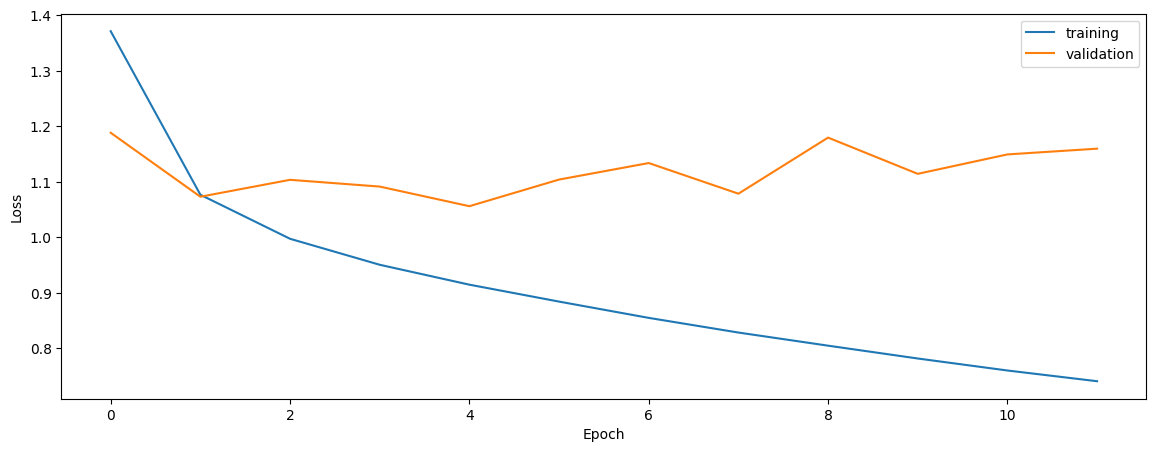

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6548340647110867
0.5840368347604362
0.5763386799345882


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5998159555859761
0.5848752151462995
0.5343026045984032


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6008242681067673
0.581362086038068
0.535626302823574


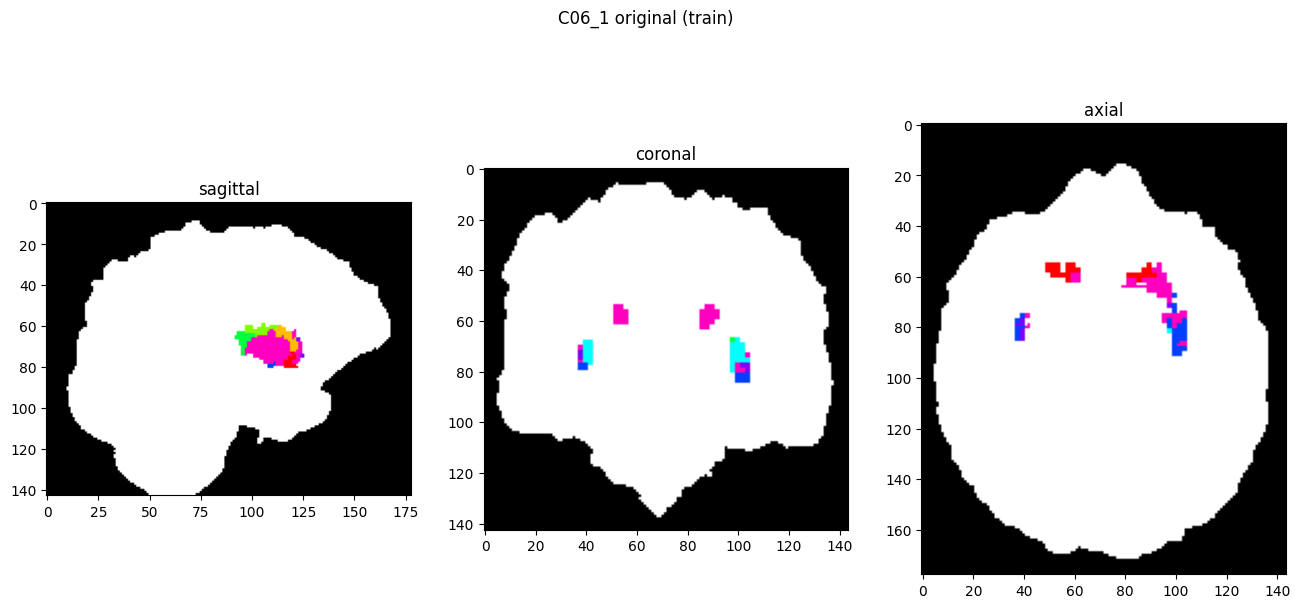

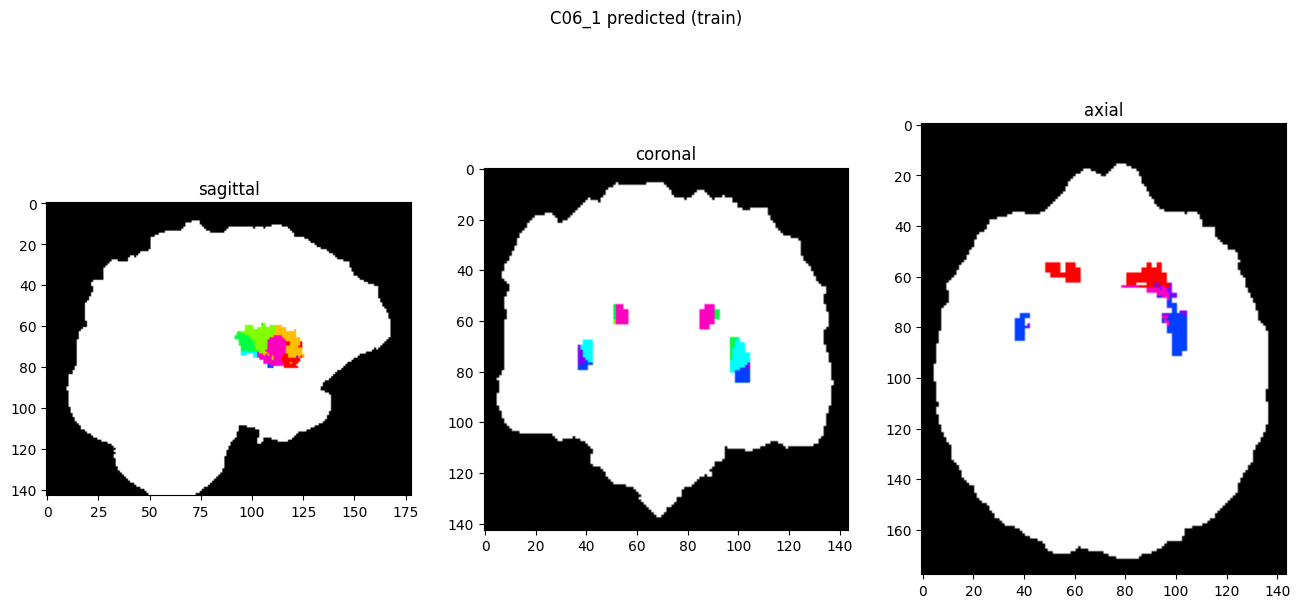

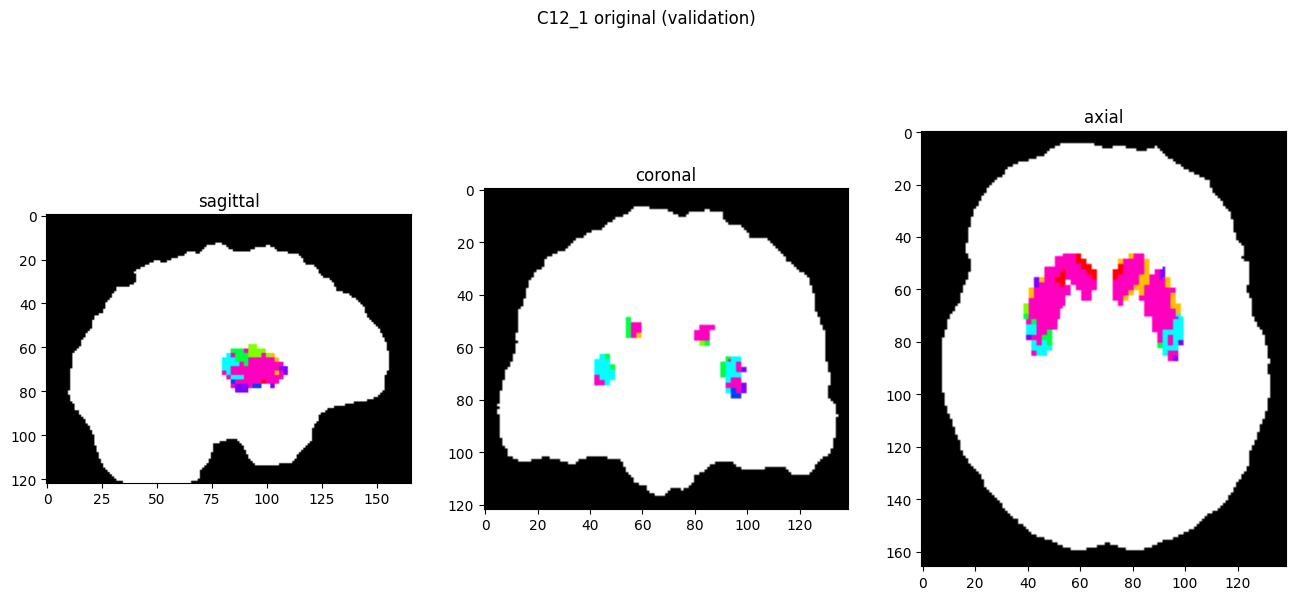

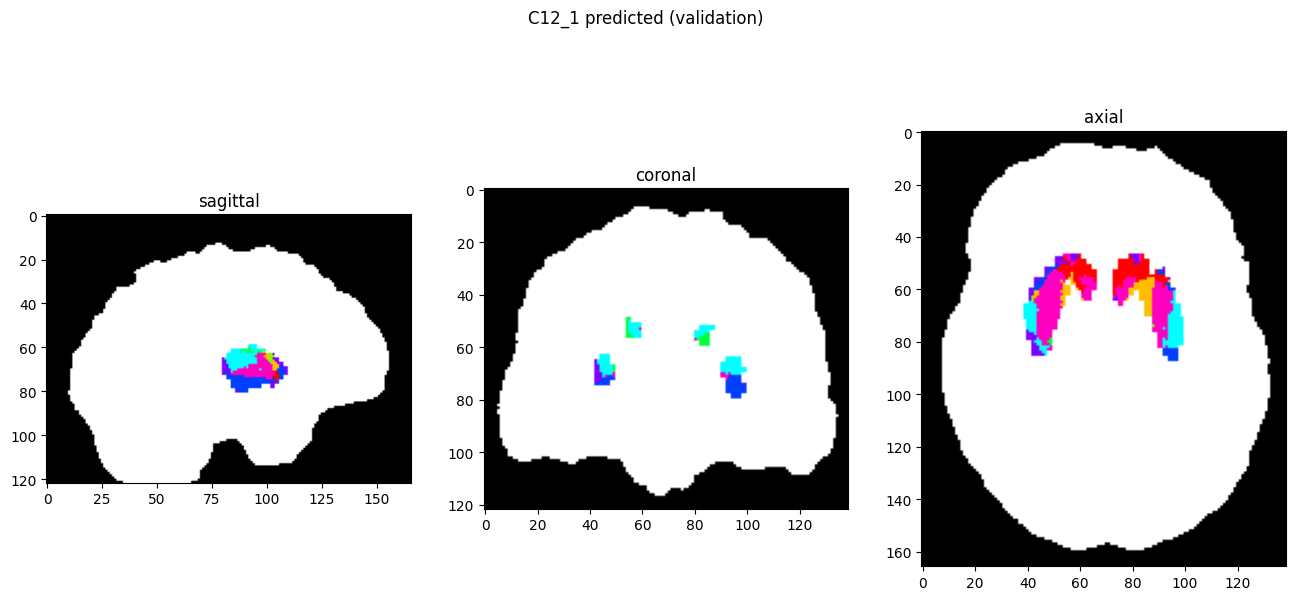

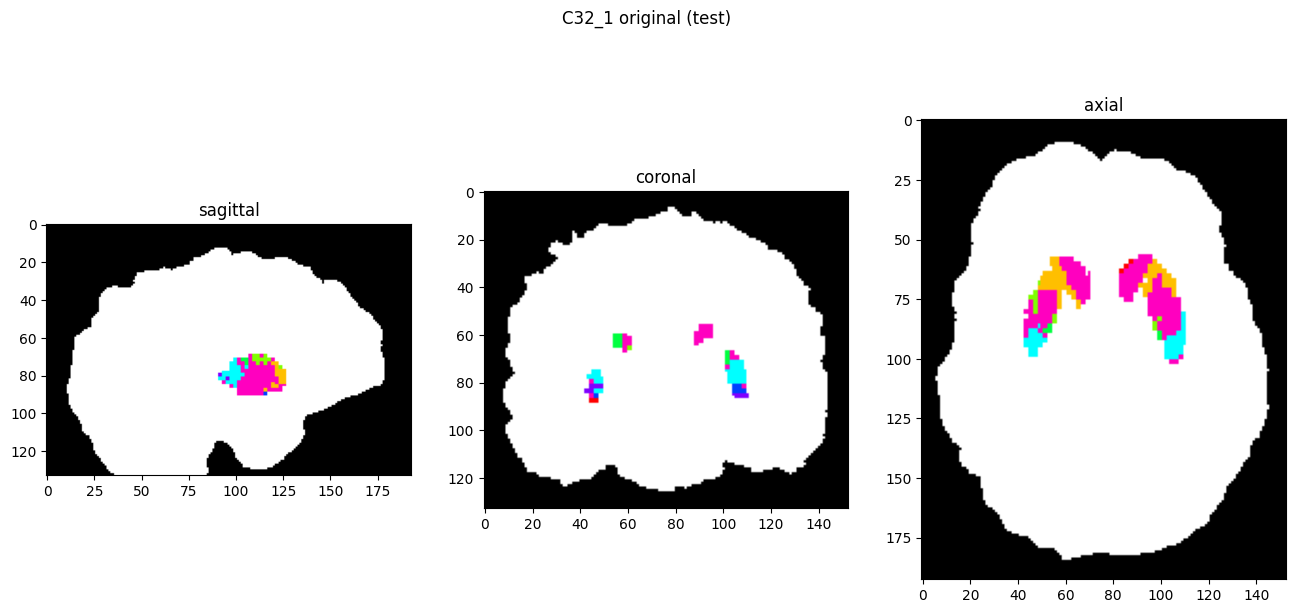

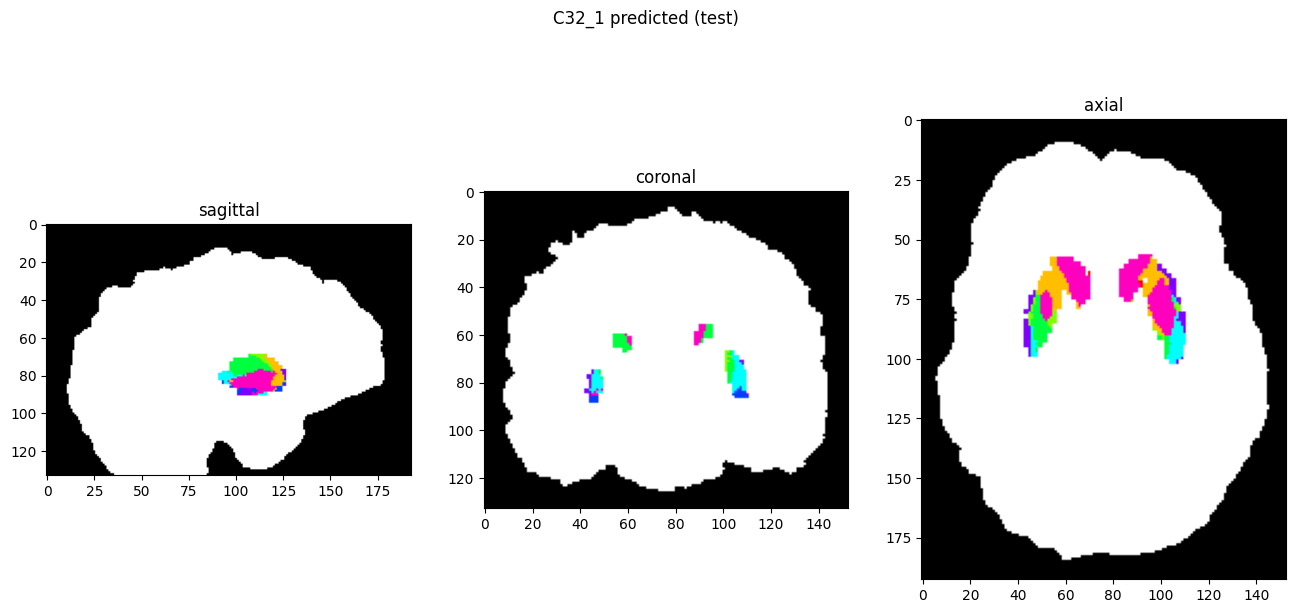

In [10]:
showResults(model, gen, threshold=0)